In [1]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hypertools as hyp
import time, glob, itertools
import geoplot as gplt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib inline

In [2]:
path = r'J:\\Geology\\WSGS\\Projects\\Critical Minerals\\probability maps\\'
allFiles=glob.glob(path+"*.csv")
frame=pd.DataFrame
listed=[]
for file in allFiles:
    df = pd.read_csv(file, index_col=[0])
    listed.append(df)
frame = pd.concat(listed)

In [3]:
huc12=gpd.read_file(r'J:\Geology\WSGS\GIS\huc_12.shp') #reads in the hydraulic basin units and adds an area column
huc12= huc12.to_crs({'init': 'epsg:3732'})


In [4]:
frame['HUC_12']=frame.HUC_12.astype(str)

In [5]:
CaptainHucstable = huc12.merge(frame, on='HUC_12' )

In [6]:
inHouse=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\inhouse_elemental.csv')

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
#writes the point data to a shapefile in the dir called data.shp
geometry = [Point(xy) for xy in zip(inHouse.longitude, inHouse.latitude)]
crs = {'init': 'epsg:3732'} 
geo_df = GeoDataFrame(inHouse, crs={'init': 'epsg:4326'}, geometry=geometry)
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')
projGeoDF=geo_df.to_crs(crs)

In [8]:
val_huc = gpd.sjoin(huc12, projGeoDF)

In [9]:
validations=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\validationmap.csv')

In [10]:
val_huc = val_huc.merge(validations, on='Sample_ID')

In [143]:
df=pd.DataFrame(columns=val_huc.columns[34:-1])
df['Sample_ID'] = val_huc.Sample_ID
choices = []
for samples in tqdm(range(len(val_huc))):
    a = val_huc.loc[samples].HUC_12 #select the samples huc
    formation = val_huc.loc[samples].formation[0:10]
    for element in range(34,99):
        ppm = val_huc.columns[element] #select each element in the list
        valued = val_huc.loc[samples][element] #select each elements values 
        #from the big list, select element, formation, and concentration greater than the sample has, and create a list of the
        #basins that we should explore
        b = CaptainHucstable[(CaptainHucstable['element']== ppm) & (CaptainHucstable['formation'].str.contains(formation)) &(
            CaptainHucstable['bins_ppm']>= valued) & (CaptainHucstable['prob']>0.5)].HUC_12.values
        if a in b:
            df[ppm].iloc[samples]=1 #if the actual HUC matches the list of predicted HUC's then we record a 1
        else: 
            df[ppm].iloc[samples]=0 #if they don't match we record a 0
        choices.append(len(b))

#df.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_60percent_probability.csv')

 99%|████████████████████████████████████████████████████████████████████████████▏| 100/101 [3:00:29<01:48, 108.29s/it]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
100%|█████████████████████████████████████████████████████████████████████████████| 101/101 [3:02:21<00:00, 108.33s/it]


In [135]:
c2 = np.reshape(choices, (101, 65))
c2[1]

array([37,  0,  0,  0,  9,  0, 36,  0, 22,  0, 14, 16, 23,  0, 88,  0, 30,
        0,  0,  0,  0,  7,  0,  0,  0,  0, 16, 26, 72,  0,  0, 29,  0, 11,
        0, 10,  0, 11,  0,  0,  0, 16,  0,  0, 15, 20, 11, 20, 16,  0,  0,
        0,  0, 19,  0,  0, 13,  0,  0, 24,  7, 13, 16, 22,  0])

In [140]:
#df=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_50percent_probability.csv')

In [144]:
d2=pd.read_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\intersection_huc12.csv')

In [145]:
'''
random sampling 
1. select in house sample HUC
2. select in house sample formation
3. build list of HUC's with formation
4. randomly select HUC's and compare overlap 
'''

"\nrandom sampling \n1. select in house sample HUC\n2. select in house sample formation\n3. build list of HUC's with formation\n4. randomly select HUC's and compare overlap \n"

In [151]:
df2=pd.DataFrame(columns=val_huc.columns[34:-1])
df2['Sample_ID'] = val_huc.Sample_ID

for samples in tqdm(range(len(val_huc)-1)):
    a = val_huc.loc[samples].HUC_12 #select the samples huc
    formation = val_huc.loc[samples].formation[0:10]
    for element in range(34,99):
        ppm = val_huc.columns[element] #select each element in the list
        try:
            options = d2[d2['Unit_Name'].str.contains(formation)].HUC_12.values
            b = np.random.choice(options, c2[element, samples]) #, np.round(len(options)*0.1).astype(int))   
            if int(a) in b:
                df2[ppm].iloc[samples]=1 #if the actual HUC matches the list of predicted HUC's then we record a 1
            else: 
                df2[ppm].iloc[samples]=0 #if they don't match we record a 0
        except:
            df2[ppm].iloc[samples]=0
        

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


In [136]:
for samples in range(len(val_huc)-1):
    for element in range(34,99):
        options = d2[d2['Unit_Name'].str.contains(formation)].HUC_10.values
        print(np.random.choice(options, c2[element, samples]))

[1404010506 1404010505 1404010504 1404010507 1404010602 1404010505
 1404010505 1404010508 1404010508 1404010504 1404010507 1404010505
 1404010504 1404010502 1404010509 1404010502 1404010507 1404010505
 1404010509 1404010505 1404010508 1404010503 1404010505 1404010505
 1404010509 1404010509 1404010505 1404010508 1404010504 1404010602
 1404010506 1404020007 1404010503 1404010505 1404010503 1404010503
 1404010506 1404010509 1404010504 1404010602 1404010503 1404010602
 1404010608 1404010509 1404010507 1404010504 1404010504 1404010508
 1404010507 1404010509 1404010508 1404010508 1404010503 1404010504
 1404010507 1404010505 1404010504 1404010509 1404010504 1404010507
 1404010507 1404010504 1404010507 1404010602 1404010506 1404010504
 1404010507 1404010506 1404010503 1404010608 1404010502 1404010506
 1404010507 1404010505 1404010505 1404010602 1404010506 1404010505
 1404010507 1404020007 1404010506 1404010506 1404010505 1404010506
 1404010505 1404010508 1404010504 1404010505 1404010507 140401

 1404010506 1404010509 1404010503 1404010506 1404010608]
[1404010508 1404010506 1404010509 1404010505 1404010505 1404010504
 1404010507 1404010508 1404010503 1404010503 1404010509 1404010509
 1404010505 1404010508 1404010507 1404010503 1404010508 1404010505
 1404010508 1404010507 1404010506 1404010608 1404010508 1404010506
 1404010507 1404010505 1404010503 1404010505 1404010503 1404010508
 1404010608 1404010509 1404010506 1404010505 1404010505 1404010507
 1404010506 1404010504 1404010506 1404010505 1404010509 1404010509
 1404010505 1404010503 1404010508 1404010504 1404010508 1404010507
 1404010506 1404010504 1404010507 1404010507 1404010507 1404010506
 1404010508 1404010507 1404010509 1404020007 1404010508 1404010509
 1404010505 1404010508 1404010507 1404010506 1404010509 1404010503
 1404010508 1404010504 1404010508 1404010608 1404010503 1404010503
 1404010505 1404010503 1404010506 1404010503 1404010503 1404010507
 1404010506 1404010509 1404010509 1404010508 1404010506 1404010504
 1404

 1404010503 1404010506]
[1404010507 1404010507 1404010507 1404010505 1404010505 1404010504
 1404010503 1404010506 1404010503 1404010507 1404010506 1404010504
 1404010505 1404010508 1404010506 1404010506 1404010507 1404010504
 1404010506 1404010504 1404010506 1404010507 1404010508 1404010506
 1404010608 1404010507 1404010507 1404010507 1404010508 1404010507
 1404010504 1404010503 1404010506 1404010508 1404010506 1404010504
 1404010509 1404010508 1404010504 1404010506 1404010507 1404010507
 1404010506 1404010505 1404010608 1404010503 1404010503 1404010509
 1404010505 1404010505 1404010508 1404010506 1404010508 1404010503
 1404010506 1404010608 1404010502 1404010505 1404010507 1404010608
 1404010502 1404010505 1404010504 1404010509 1404010507 1404010506
 1404010503 1404010504 1404010504 1404010503 1404010608 1404010507
 1404020007 1404010507 1404010503 1404010504 1404010506 1404010507
 1404010508 1404010508 1404010505 1404010608 1404010504 1404010506
 1404010506 1404010506 1404010506 1404

 1404010509]
[1404010509 1404010507 1404010505 1404010503 1404010506 1404010505
 1404010509 1404010505 1404010608 1404010503 1404010505 1404010506
 1404010502 1404010509 1404010508 1404010502 1404010506 1404010509
 1404010503 1404010508 1404010509 1404010608 1404010508 1404010506
 1404010506 1404010503 1404010507 1404010505 1404010506 1404010502
 1404010505 1404010507 1404020007 1404010608 1404010507 1404010509
 1404010602 1404010504 1404010503 1404010505 1404010608 1404010507
 1404010608 1404010505 1404010508 1404010507 1404010509 1404010507
 1404010502 1404010602 1404010507 1404010503 1404010508 1404010508
 1404010507 1404010505 1404010505 1404010505 1404010507 1404010504
 1404010506 1404010508 1404010505 1404010505 1404010502 1404020007
 1404010506 1404010506 1404010504 1404010507 1404010506 1404010502
 1404010506 1404010505 1404010508 1404010505 1404010505 1404010503
 1404010504 1404010503 1404010509 1404010504 1404010505 1404010504
 1404010505 1404010503 1404010508 1404010506 1404

 1404010506 1404010602 1404010507 1404010502 1404010602 1404010507]
[1404010506 1404010506 1404010507 1404020007 1404010509 1404010507
 1404010506 1404010508 1404010507 1404010506 1404010505 1404010505
 1404010503 1404010504 1404010505 1404010508 1404010504 1404010507
 1404010602 1404010503 1404010504 1404010503 1404010507 1404010508
 1404010509 1404010506 1404010505 1404010608 1404010602 1404010509
 1404010508 1404010508 1404010508 1404010602 1404010507 1404010505
 1404010508 1404010507 1404010504 1404010508 1404010503 1404010506
 1404010507 1404010602 1404010504 1404010506 1404010505 1404010506
 1404020007 1404010608 1404010505 1404010505 1404010506 1404010506
 1404010506 1404010508 1404010504 1404010506 1404010505 1404010503
 1404010505 1404010503 1404010504 1404010505 1404010503 1404010503
 1404010508 1404010506 1404010505 1404010506 1404010507 1404010506
 1404020007 1404010505 1404010508 1404010508 1404010508 1404010608
 1404010506 1404010503 1404010507 1404010509 1404010507 14040

 1404010505 1404010507 1404010505 1404010505 1404010503 1404010505]
[1404010602 1404010507 1404010508 1404010505 1404010506 1404010602
 1404010508 1404010506 1404010509 1404010505 1404010505 1404010504
 1404010506 1404010507 1404020007 1404010503 1404010509 1404010507
 1404010503 1404010504 1404010608 1404010504 1404010503 1404010508
 1404010504 1404010505 1404010506 1404010508 1404010506 1404010506
 1404010504 1404010504 1404010508 1404010507 1404010506 1404010503
 1404010507 1404010508 1404010505 1404020007 1404010508 1404010509
 1404010503 1404010507 1404010505 1404010602 1404010506 1404010508
 1404010507]
[1404010504 1404010508 1404010506 1404010505 1404010507 1404010504
 1404010505 1404010602 1404010506 1404010508 1404010503 1404010505
 1404010508 1404010509 1404010509 1404010502 1404010504 1404010507
 1404010504 1404010504 1404010504 1404010505 1404010507 1404010509
 1404010507 1404010505 1404010507 1404010507 1404010504 1404010506
 1404010504 1404010507 1404010504 1404010504 140

 1404010505]
[1404010505 1404010507 1404010505 1404010503 1404010508 1404010608
 1404010505 1404010507 1404010507 1404010506 1404010602 1404010504
 1404010507 1404010504 1404010608 1404010504 1404010506 1404010506
 1404010505 1404010507 1404010509 1404010507 1404010509 1404010509
 1404010504 1404010508 1404010506 1404010503 1404010602 1404010507
 1404010506 1404010608 1404010506 1404010509 1404010507 1404010503
 1404010602 1404010506 1404010602 1404010508 1404010504 1404010509
 1404010608 1404010505 1404010506 1404010507 1404010505 1404010506
 1404010505 1404010506 1404010507 1404010504 1404010602 1404010602
 1404010504 1404010509 1404010503 1404010507 1404010504 1404010509
 1404010508 1404010507 1404010505 1404010509 1404010507 1404010508
 1404010506 1404010508 1404010508 1404010502 1404010503 1404010508
 1404010507 1404010507 1404010503 1404010508 1404010509 1404010509
 1404010507 1404010509 1404010504 1404010503 1404010608 1404010509
 1404010509 1404010505 1404010505 1404010507 1404

 1404020007 1404010508 1404010608]
[]
[]
[]
[1404010504 1404010505 1404010608 1404010509 1404010507 1404010508
 1404010509 1404010503 1404010508 1404010504 1404010506 1404010504
 1404010608 1404010508 1404010505 1404010505 1404010608 1404010508
 1404010507 1404010608 1404010507 1404010509 1404010507 1404010506
 1404010505 1404010502 1404010608 1404010506 1404010507 1404010507
 1404010505 1404010507 1404010507 1404010503 1404010505 1404010505
 1404010505 1404010505 1404010509 1404010503 1404010507]
[1404010509 1404010504 1404010507 1404010504 1404010507 1404010508
 1404010509 1404010508 1404010506 1404010509 1404010508 1404010503
 1404010502 1404010505 1404010608 1404010505 1404010503 1404010506
 1404010508 1404010508 1404010506 1404010506 1404010504 1404010509
 1404010608 1404010507]
[]
[1404010505 1404010506 1404010608 1404010509 1404010505 1404010507
 1404010506 1404010508 1404010505 1404010505 1404010602 1404010506
 1404010508 1404010506 1404010506 1404010507 1404010506 1404010608
 

 1404010505 1404010608 1404010503 1404010508 1404010509]
[1404010506 1404010507 1404010505 1404010508 1404010505 1404010608
 1404010506 1404010508 1404010505 1404010608 1404010505 1404010508
 1404010509 1404010505 1404010506 1404010505 1404010506 1404010509
 1404010506 1404020007 1404010503 1404020007 1404010502 1404010506
 1404010505 1404010508 1404010502 1404010503 1404010509 1404010505
 1404010502 1404010507 1404010608 1404010507 1404010602 1404010506
 1404010505 1404010504 1404010507 1404010505 1404010505 1404010507
 1404010509 1404010505 1404010505 1404010509 1404010508 1404010505
 1404010506 1404010504 1404010508]
[1404010507 1404010509 1404010506 1404010509 1404010508 1404010509
 1404010507 1404010509 1404010508 1404010504 1404010608 1404010505
 1404010506 1404010505 1404010503 1404010507 1404010508 1404010508
 1404010502 1404010507 1404010505 1404010503 1404010503 1404010506
 1404010507 1404010502 1404010507 1404010505 1404010505 1404010505
 1404020007 1404010505 1404010503 140

 1404010503 1404010509 1404010509 1404010508 1404010508 1404010509]
[1404010505 1404010509 1404010506 1404020007 1404010508 1404010503
 1404010508 1404010608 1404010504 1404010507 1404010506 1404010503
 1404010508 1404010504 1404010505 1404010506 1404010602 1404010506
 1404010505 1404010509 1404010602 1404010506 1404010508 1404010507
 1404010507 1404010509 1404010505 1404010505 1404010505 1404010505
 1404010506 1404010507 1404010503 1404010502 1404010503 1404010509
 1404010505 1404010503 1404010506 1404010505 1404010503 1404010509
 1404010505 1404010508 1404010509 1404010505 1404010508 1404010504
 1404010505 1404010507 1404010506 1404010506 1404010504 1404010508
 1404010507 1404010505 1404010505 1404010509 1404010502 1404010505
 1404010506 1404010507 1404010504 1404010506]
[1404010507 1404020007 1404010507 1404010508 1404020007 1404010509
 1404010503 1404010508 1404010505 1404010508 1404010503 1404010508
 1404010507 1404010507 1404010508 1404010506 1404010506 1404010502
 1404010509 140

 1404010503]
[]
[1404010508 1404010507 1404010602 1404010504 1404010503 1404010508
 1404010503 1404010509 1404010507 1404010504 1404010506 1404010602
 1404010509 1404010505 1404010509 1404010506 1404010509 1404010507
 1404010507 1404010503]
[]
[]
[]
[]
[]
[]
[1404010506]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[1404010506 1404010503 1404010503 1404010608 1404010506 1404010508
 1404010508 1404010608 1404010508 1404010505 1404010505 1404010508
 1404010602 1404010507 1404010503 1404010505 1404010507 1404010509
 1404010508 1404010508 1404010507 1404010507 1404010602 1404010602
 1404010506 1404010507 1404010506 1404010506 1404010507 1404010505
 1404010505 1404010505 1404010505 1404010508 1404010508 1404010504
 1404010503 1404010505 1404010506 1404010509 1404010509 1404010505
 1404010509 1404010507 1404010505 1404010508 1404010507 14

 1404010502]
[1404010507 1404010503 1404010507 1404010509 1404010608 1404010608
 1404010608 1404010508 1404010506 1404010509 1404010507 1404010505
 1404010508 1404010506 1404010508 1404010507 1404010505 1404010502
 1404010504 1404010507 1404010608 1404010508 1404010506 1404020007
 1404010508 1404010504 1404010608 1404010503 1404010506 1404010509
 1404010504 1404010507 1404010509 1404010506 1404010505 1404010503
 1404010509 1404010503 1404010508 1404010505 1404010505 1404020007
 1404010507 1404010506 1404010503 1404020007 1404010508 1404010509
 1404010505 1404010508 1404010508 1404010508 1404010507 1404010508
 1404010504 1404010506 1404010506 1404010506 1404010505 1404010509
 1404010503 1404010508 1404010506 1404010506 1404010505 1404010508
 1404010509 1404010507 1404010602 1404010503 1404010502 1404010503
 1404010505 1404010503 1404010507 1404010505 1404010504 1404010505
 1404010507 1404010505 1404010608 1404010507 1404010507 1404010502
 1404010503 1404010506 1404010505 1404010506 1404

 1404010507 1404010507 1404010508 1404010505 1404010508 1404010503]
[]
[1404010602 1404010509 1404010506 1404010508 1404010502 1404010508
 1404010504 1404010508 1404020007 1404010505 1404010504 1404010508
 1404010506 1404010505 1404010507 1404010504 1404010508 1404010508
 1404010507 1404010506 1404010507 1404010503 1404010506 1404010507
 1404010507 1404010506 1404010505 1404010506 1404010503 1404010505
 1404010505 1404010506 1404010505 1404010503 1404010509 1404010507
 1404010509 1404010505 1404010608 1404010602 1404010507 1404010508
 1404010608 1404010506 1404010608 1404010508 1404010509 1404010507
 1404010508 1404010506 1404010507 1404010506 1404010507 1404010508
 1404010506 1404010504 1404010509 1404010509 1404010503 1404010506
 1404010504 1404010602 1404010508 1404010507 1404010506 1404010602
 1404010508 1404010509 1404010509 1404010509 1404010506 1404010508
 1404010509 1404010504 1404010504 1404020007 1404010508 1404010503
 1404010505 1404010506 1404010507 1404010505 1404020007 14

 1404010503 1404010505]
[1404010509 1404010505 1404010503 1404010508 1404010505 1404010509
 1404010509 1404010505 1404010508 1404010506 1404010506 1404010503
 1404010507 1404010508 1404010506 1404010504 1404010503 1404010505
 1404010505 1404010509 1404010508 1404010507 1404010507 1404010602
 1404010507 1404010508 1404010505 1404010507 1404010506 1404010505
 1404010502 1404010507 1404010504 1404010505 1404010504 1404010506
 1404010508 1404010505 1404010505 1404010507 1404010506 1404010503
 1404010503 1404010507 1404010503 1404010505 1404010504 1404010506
 1404010503 1404010509 1404010602 1404010504 1404010509 1404010507
 1404010503 1404010504 1404010506 1404010503 1404010508 1404010508
 1404010507 1404010508 1404010502 1404010505 1404020007 1404020007
 1404010503 1404010508 1404010507 1404010505 1404010504 1404010509
 1404010507 1404010507 1404010506 1404010505 1404010507 1404010506
 1404010504 1404020007 1404010502 1404010505 1404010506 1404010509
 1404010503 1404010504 1404010506 1404

 1404010509 1404010507 1404010509]
[1404010509 1404010504 1404010506 1404010506 1404010505 1404010502
 1404010503 1404010503 1404010506 1404010508 1404010502 1404010504
 1404010502 1404010506 1404010505 1404010509 1404010507 1404010505
 1404010504 1404010505 1404010506 1404010509 1404010509 1404010506
 1404010509 1404010508 1404010503 1404010504 1404010608 1404010505
 1404010508 1404010507 1404010508 1404010608 1404010509 1404010505
 1404010504 1404010507 1404010503 1404010505 1404010608 1404010503
 1404010505 1404020007 1404010503 1404010505 1404010506 1404010503
 1404010504 1404010507 1404010508 1404010506 1404010504 1404010504
 1404010508 1404010506 1404010602 1404010508 1404010505 1404010505
 1404010508 1404010505 1404010505 1404010505 1404010503 1404010507
 1404010508 1404010504 1404010608 1404010602 1404010503 1404010508
 1404010508 1404010509 1404010507 1404010507 1404010508 1404010505
 1404010505 1404010508 1404010505 1404010602 1404010508 1404010507
 1404010508 1404010507 1404

 1404010507]
[1404010602 1404010503 1404010509 1404010508 1404010505 1404010505
 1404010507 1404010506 1404010507 1404010509 1404010507 1404010505
 1404010507 1404010503 1404010602 1404010509 1404010508 1404010505
 1404010503 1404010505 1404010508 1404010507 1404010509 1404010505
 1404010602 1404010503 1404010608 1404010504 1404010508 1404010509
 1404010507 1404010509 1404010507 1404010506 1404010505 1404010504
 1404020007 1404010506 1404020007 1404010509 1404010508 1404010508
 1404010508 1404010508 1404010507 1404010506 1404010505 1404010509
 1404010502 1404010506 1404010507 1404010505 1404010503 1404010504]
[1404010505 1404010509 1404010508 1404010608 1404010506 1404010508
 1404010509 1404010507 1404010507 1404010505 1404010506 1404010503
 1404010509 1404010508 1404010502 1404010602 1404010507 1404010506
 1404010502 1404010608 1404010506 1404010506 1404010503 1404010507
 1404010509 1404010508 1404010507 1404010602 1404010508 1404010508
 1404010508 1404010504 1404010503 1404010506 140

 1404010504]
[1404010508 1404010505 1404010509 1404010507 1404010508 1404010503
 1404010508 1404010502 1404010507 1404010505 1404010602 1404010505
 1404010507 1404010506 1404010506 1404010508 1404010509 1404010507
 1404010504 1404010506 1404010505 1404010507 1404010508 1404010506
 1404010508 1404010503 1404010608 1404010505 1404010507 1404010506
 1404010506 1404010508 1404010506 1404010509 1404010602 1404010602
 1404010505 1404020007 1404010507 1404020007 1404010508 1404010502
 1404010503 1404010504 1404010602 1404010506 1404010504 1404010504
 1404010507 1404010506 1404010509 1404010509 1404010506 1404010505]
[1404010505 1404010504 1404010506 1404010505 1404010506 1404010504
 1404010505 1404010507 1404010507 1404010505 1404010505 1404010503
 1404010505 1404010505 1404010602 1404010507 1404010504 1404010508
 1404010507 1404010506 1404010504 1404010504 1404010506 1404010508
 1404010507 1404010509 1404010508 1404010505 1404010508 1404010504
 1404010506 1404010508 1404010507 1404010508 140

 1404010504]
[1404010503 1404010506 1404020007 1404010507 1404010505 1404010505
 1404010507 1404010506 1404010504 1404010506 1404010505 1404010506
 1404010509 1404010503 1404010509 1404010504 1404010505 1404010505
 1404010508 1404010505 1404010505 1404010503 1404010506 1404010508
 1404010507 1404010602 1404010509 1404010509 1404010507 1404010508
 1404010507 1404010504 1404010509 1404020007 1404010509 1404010507
 1404010505 1404010503 1404010506 1404010508 1404010506 1404010508
 1404010504 1404010506 1404010506 1404010505 1404010504 1404010507
 1404010506 1404010506 1404010509 1404010506 1404010608 1404010508
 1404010506 1404010506 1404010502 1404010504 1404010507 1404010506
 1404010509 1404010506 1404010506 1404010506 1404010506 1404010505
 1404010506 1404010602 1404010505 1404010509 1404010507 1404010506
 1404010608 1404010504 1404010504 1404010508 1404010608 1404010508
 1404010506 1404010506 1404010506 1404010608 1404010602 1404010509
 1404010504 1404020007 1404010504 1404020007 1404

 1404010503 1404010506 1404010505 1404010505 1404010509]
[1404010509 1404010602 1404010507 1404010509 1404010506 1404010505
 1404010507 1404010503 1404010505 1404010507 1404010505 1404010506
 1404010507 1404010508 1404010509 1404010506 1404010508 1404010509
 1404010505 1404010608 1404010505 1404010506 1404010509 1404010507
 1404010509 1404010504 1404010506 1404010505 1404010507 1404010508
 1404010602 1404010505 1404010506 1404010505 1404010508 1404020007
 1404010505 1404010503 1404010507 1404010508 1404020007 1404010509
 1404010503 1404010507 1404010504 1404010505 1404010508 1404010506
 1404010508 1404010507 1404020007 1404010504 1404010506 1404010503
 1404010505 1404010503 1404010506 1404010506 1404010507 1404010505
 1404010507 1404010502 1404010507 1404010504 1404010507 1404010507
 1404010508 1404010509 1404010504 1404010506 1404010505 1404010608
 1404010504 1404010506 1404010508 1404010503 1404010508 1404010504
 1404010504 1404010508 1404010508 1404010504 1404010507 1404010508
 1404

 1404010509 1404010507 1404010506 1404010509]
[1404010506 1404010505 1404010602 1404010507 1404010503 1404010506
 1404010506 1404010503 1404010508 1404010602 1404010507 1404010507
 1404010504 1404010508 1404010506 1404010507 1404010506 1404010507
 1404010503 1404010602 1404010504 1404010504 1404010506 1404010508
 1404010508 1404010506 1404010508 1404010504 1404010509 1404010503
 1404010506 1404010506 1404010507 1404010508 1404010505 1404010507
 1404010508 1404010504 1404020007 1404010507 1404010509 1404010505
 1404010508 1404010504 1404010506 1404010506 1404010506 1404010505
 1404010505 1404010508 1404010508 1404010505 1404010506 1404010506
 1404010507 1404010506 1404010504 1404010506 1404010602 1404010505
 1404010506 1404010508 1404010507 1404010505 1404010503 1404010508
 1404010608 1404010509 1404010506 1404010504 1404010508 1404010507
 1404010505 1404010504 1404010508 1404010508 1404010602 1404010505
 1404010508 1404010509 1404010508 1404010507 1404010505 1404010508
 1404010506 1404

 1404010608 1404010508 1404010608 1404010602]
[1404010505 1404010506 1404010502 1404010506 1404010506 1404010505
 1404010608 1404010504 1404010505 1404010506 1404010505 1404010508
 1404010505 1404010602 1404010508 1404010504 1404010506 1404020007
 1404010505 1404010508 1404010505 1404010608 1404010505 1404010509
 1404020007 1404010504 1404010505]
[1404010509 1404010608 1404010509 1404010503 1404010608 1404010509
 1404010505 1404010508 1404010602 1404010505 1404010507 1404010503
 1404010509 1404010508 1404010506 1404010506 1404010506 1404010508
 1404010506 1404010504 1404010602 1404010507 1404010608 1404010507
 1404010508 1404010506 1404010507]
[1404010507 1404010506 1404010504 1404010506 1404010507 1404010509
 1404010507 1404010507 1404010506 1404010507 1404010505 1404010505
 1404010608 1404010505 1404010507 1404010508 1404010506 1404010509
 1404010506 1404010506 1404010507 1404010505 1404010506 1404010506
 1404010507 1404010505 1404010602]
[1404010503 1404010503 1404010507 1404010507 

 1404010504 1404010504 1404010507]
[]
[]
[]
[]
[1404010505 1404010507 1404010505 1404010505 1404010508 1404010505
 1404010503 1404010507 1404010504 1404010504 1404010505 1404010505
 1404010502 1404010505 1404010509 1404010602 1404010503 1404010505
 1404010504]
[1404010502 1404010502 1404010508 1404010505 1404010508 1404010506
 1404010505 1404010508 1404010602 1404010508 1404010506 1404010508
 1404010506 1404010508 1404010505 1404010507 1404010503 1404010504
 1404010507]
[1404010506 1404010503 1404010506 1404010509 1404010509 1404010507
 1404010505 1404010503 1404010503 1404010508 1404010506 1404010504
 1404010507 1404010602 1404010608 1404010507 1404010507 1404010509
 1404010505]
[1404010508 1404010508 1404010602 1404010508 1404010509 1404010508
 1404010508 1404010509 1404020007 1404010509 1404010507 1404010509
 1404010509 1404010503 1404010505 1404010508 1404010504 1404010504
 1404010504]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

 1404010503 1404010504 1404010505 1404010602]
[]
[1404010509 1404010508 1404010508 1404010506 1404010505 1404010505
 1404010507 1404010506 1404010507 1404010508 1404010505 1404010504
 1404010504 1404010508 1404010508 1404010509 1404010507 1404010608
 1404010602 1404010506 1404010507 1404010509 1404010507 1404010505
 1404010608 1404010509 1404010507 1404010508 1404010506 1404010509
 1404010502 1404010504 1404010506 1404010602 1404010506 1404010503
 1404010506 1404010506 1404010508 1404010507 1404010508 1404010602
 1404010503 1404010505 1404010505 1404010503 1404010503 1404010505
 1404010503 1404010506 1404010507 1404010503 1404010508 1404010507
 1404010503 1404010509 1404010509 1404010506 1404010503 1404010503
 1404010506 1404010503 1404010508 1404010507 1404010505 1404010504
 1404010507 1404010608 1404010503 1404010506 1404010508 1404010505
 1404010504 1404010506 1404010503 1404010608 1404010505 1404010504
 1404010502 1404010503 1404010505 1404010503 1404010507 1404010507
 1404010505 1

 1404010507 1404010608 1404010503]
[1404010608 1404010608 1404010507 1404010504 1404010502 1404010508
 1404010608 1404010508 1404010508 1404010505 1404010502 1404010506
 1404010503 1404010507]
[1404010505 1404010503 1404010506 1404010608 1404010505 1404010506
 1404010602 1404010505 1404010508 1404010506 1404010503 1404010505
 1404010506 1404010503 1404010504 1404010505 1404010505 1404010506
 1404010509 1404010507 1404010608]
[1404010506 1404010503 1404010507 1404010507 1404010504]
[1404010507 1404010503 1404010505 1404010505 1404010504 1404010503
 1404010509 1404010608 1404010507 1404010608 1404010503 1404020007
 1404010602 1404010506]
[]
[]
[]
[1404010506 1404010503 1404010509 1404010505 1404010505 1404010503
 1404010508 1404010508 1404010507 1404010602 1404010506 1404010504
 1404010608 1404010602 1404010507 1404010608 1404010503 1404010508
 1404010505 1404010507 1404010502 1404010509 1404010507 1404010508
 1404010506 1404010507 1404010508 1404010508 1404010507 1404010505
 1404010503 

 1404010509 1404010508 1404010507 1404010504 1404010507 1404010504]
[]
[]
[1404010506 1404010509 1404010608 1404010608 1404010507 1404010506
 1404010507 1404010504 1404010504 1404010505 1404010508 1404010502
 1404010507 1404010507 1404010509 1404010509 1404010503 1404010504
 1404010508 1404010506 1404010508 1404010507 1404010502 1404010602
 1404010506 1404010507 1404010506 1404010508 1404010509 1404010509
 1404010508 1404010503 1404010506 1404010602 1404010508 1404010602
 1404010508 1404010503 1404010507 1404010508 1404010504 1404010505
 1404010602 1404010608 1404010509]
[1404010502 1404010505 1404010507 1404010602 1404010509 1404010505
 1404010509 1404010509 1404010508 1404010502 1404010507 1404010505
 1404010509 1404010506 1404010505 1404010507 1404010508 1404010508
 1404010504 1404010505 1404010507 1404010507 1404010506 1404010509
 1404010508 1404010506 1404010505 1404010504 1404010505 1404010504
 1404010507 1404010505 1404010509 1404010508 1404010505 1404010503
 1404010507 14040106

 1404010504 1404010506]
[]
[1404010508 1404010503 1404010503 1404010507 1404010505 1404010505
 1404010506 1404010503 1404010504 1404010503 1404010506 1404010509
 1404010608 1404010505 1404010507 1404010506 1404010608 1404010509
 1404020007 1404010602 1404010506 1404010503 1404010502 1404010505
 1404010506 1404010504 1404010509 1404010507 1404010505 1404010505
 1404010505 1404010507 1404010508 1404010503 1404010503 1404010508
 1404010508 1404010507 1404010508 1404010507 1404010505 1404010506
 1404010508 1404010602 1404010508 1404010509 1404010608 1404010505
 1404010503 1404010505 1404010508 1404010507 1404010507 1404010509
 1404010506 1404010503 1404010505 1404010508 1404010508 1404010503
 1404010505 1404010504 1404010505 1404010506 1404010508 1404010506
 1404010503 1404010507 1404010508 1404010507 1404010505 1404010504
 1404010508 1404010509 1404010504 1404010509 1404010602 1404010505
 1404010509 1404010602 1404010507 1404010509 1404010507 1404010506
 1404010509 1404010503 1404010507 1

 1404010506]
[]
[1404010508 1404010509 1404010505 1404010509 1404010504 1404010508
 1404010505 1404010508]
[]
[]
[1404010506 1404010509 1404010506 1404010503 1404010508 1404010506
 1404010508 1404010509]
[1404010504 1404010507 1404010503 1404010506 1404010508 1404010505
 1404010509 1404010504 1404010507 1404010508 1404010505 1404010508
 1404010505 1404010507 1404010507 1404010602 1404010507 1404010506
 1404010503 1404010507 1404010507]
[]
[1404010506 1404010504 1404010506 1404010506 1404010504 1404010508
 1404010608 1404010503 1404010506 1404010507 1404010504 1404010503
 1404010507 1404010509 1404010509 1404010506 1404010508 1404010507
 1404010503 1404010507 1404010507 1404010506 1404010506 1404010608
 1404010505 1404010502 1404010506 1404010504 1404010503 1404010509
 1404010503 1404010608 1404010508 1404010509 1404010508 1404010507
 1404010505 1404010507 1404010507 1404010505 1404010506 1404010505
 1404010509 1404010602 1404010602 1404010506 1404010504 1404010503
 1404010505 140401050

 1404010507 1404010506 1404010509 1404010503]
[1404010507 1404010506 1404010506 1404010507 1404010506 1404010504
 1404010508 1404010507 1404010505 1404020007 1404010608 1404010507
 1404010506 1404010508 1404010508 1404010506 1404010505 1404010505
 1404010508 1404010506 1404010508 1404010505 1404010506 1404010508
 1404010608 1404010507 1404010509 1404010507 1404020007 1404010503
 1404010608 1404010507 1404010508 1404010504 1404010507 1404010506
 1404010509 1404010507 1404010506 1404010503 1404010608 1404010509
 1404010507 1404010503 1404010504 1404010507 1404010507 1404010503
 1404010503 1404010505 1404010504 1404010504 1404010506 1404010508
 1404010508 1404010505 1404010503 1404010507 1404010504 1404010602
 1404010509 1404010508 1404010504 1404010505 1404010505 1404010503
 1404010508 1404010505 1404010508 1404010507 1404010505 1404010506
 1404010608 1404010507 1404010508 1404010508 1404010502 1404010502
 1404010509 1404020007 1404010504 1404010608 1404010602 1404010608
 1404010503 1404

 1404010509 1404010507]
[]
[]
[]
[]
[]
[1404010503 1404010507 1404010504 1404010505 1404010506 1404010503
 1404010508 1404010504 1404010508 1404010508 1404010505 1404010507
 1404010503 1404010506 1404010507 1404010506 1404010506 1404010508
 1404010608 1404010602 1404010506 1404010506 1404010505 1404010508
 1404010507 1404010503 1404010505 1404010507 1404010506 1404010502
 1404010508 1404010506 1404010508 1404010505 1404010509 1404010506
 1404010508 1404010508 1404010506 1404010505 1404010509 1404010503
 1404010502 1404010502 1404010509 1404010505 1404010505 1404010506
 1404010507 1404010505 1404010508 1404010509 1404010506 1404010503
 1404010503 1404010505 1404010505 1404010608 1404010504 1404010506
 1404010608 1404020007 1404010509 1404010506 1404010506 1404010502
 1404010503 1404010502 1404010502 1404010505 1404010506 1404010503
 1404010507 1404010505 1404010506 1404010507 1404010509 1404010505
 1404010506 1404010507 1404010506 1404010608 1404010506 1404010506
 1404010508 1404010506 

 1404010506 1404010608]
[1404010507 1404010507 1404010507 1404010504 1404010505 1404010508
 1404010608 1404010504 1404010505 1404010503 1404010608 1404010504
 1404010504 1404010507 1404010506 1404010503 1404010508 1404010504
 1404010507 1404010504 1404010602 1404010507 1404010506 1404010508
 1404010507 1404010505 1404010508 1404010506 1404010505 1404010505
 1404010506 1404010509 1404010507 1404010506 1404010509 1404010503
 1404010508 1404010508 1404010507 1404010508 1404010509 1404010505
 1404010509 1404010505 1404010503 1404010508 1404010504 1404010504
 1404010508 1404010507 1404010504 1404010503 1404010506 1404010506
 1404010507 1404010503 1404020007 1404010504 1404010507 1404010508
 1404010503 1404010505 1404010503 1404010508 1404010509 1404010506
 1404010506 1404010504 1404010507 1404010504 1404010505 1404010507
 1404010508 1404010509 1404010506 1404010509 1404010509 1404010608
 1404010505 1404010505 1404020007 1404010505 1404010505 1404010505
 1404010507 1404010504 1404010505 1404

 1404010508 1404010505 1404010507 1404010507]
[1404010508 1404010505 1404010505 1404010508 1404010506 1404010505
 1404010509 1404010508 1404010509 1404010502 1404010504 1404010506
 1404010504 1404010507 1404010505 1404010508 1404010505 1404010502
 1404010503 1404010507 1404010608 1404010503 1404010506 1404010505
 1404010508 1404010504 1404010508 1404010507 1404010508 1404010509
 1404010602 1404010608 1404010503 1404010602 1404010502 1404010503
 1404010509 1404010505 1404010509 1404010505 1404010602 1404010505
 1404010602 1404010505 1404010503 1404010509 1404010505 1404010507
 1404010509 1404010509 1404010506 1404010505 1404010504 1404010505
 1404010504 1404010506 1404010505 1404010509 1404010506 1404010508
 1404010504 1404010505 1404010506 1404010509 1404010507 1404010508
 1404010506 1404010507 1404010508 1404010505 1404010505 1404010509
 1404010505 1404010509 1404010602 1404010507 1404010508 1404010508
 1404010506 1404010507 1404010507 1404010503 1404010504 1404010602
 1404010508 1404

 1404010507 1404010506 1404010505]
[]
[]
[1404010505 1404010504 1404020007 1404010506]
[1404010505 1404010608 1404010508 1404010503]
[]
[]
[]
[]
[1404010509 1404010505 1404010505 1404010505 1404010509 1404010506
 1404010508 1404010509 1404010608 1404010508 1404010507]
[1404010506 1404010507 1404010608 1404010505 1404010503 1404010509
 1404010504 1404010503 1404010608 1404010507 1404010508]
[1404010506 1404010507 1404010608 1404010507 1404010506 1404010608
 1404010508 1404010505 1404010608 1404010504 1404010506]
[1404010507 1404010506 1404010505 1404010505 1404010508 1404010503
 1404010504 1404010507 1404010507 1404010508 1404010507]
[]
[]
[]
[]
[]
[]
[1404010508 1404010505 1404010503 1404010508 1404010504 1404010509
 1404010506 1404010506 1404010503 1404010508 1404010508 1404010507
 1404010506 1404010505 1404010506 1404010508 1404010504 1404010507
 1404010503 1404010507 1404010505 1404010506 1404010507 1404010602
 1404010505 1404010608 1404010506 1404010507 1404010506 1404010506
 14040

 1404010507 1404010509 1404010503]
[]
[]
[]
[]
[]
[1404010502 1404010608 1404010505 1404010505 1404010508 1404010505
 1404010507 1404010602 1404010504 1404010506 1404010509 1404010509
 1404010503 1404010507 1404010608 1404010509 1404010504 1404010504
 1404010602 1404010608 1404010507 1404010506 1404010507 1404010504
 1404010508 1404010503 1404010508 1404010506 1404010503 1404010504
 1404010507 1404010602 1404010503 1404010508 1404010509 1404010505
 1404010504 1404010507 1404010508 1404010505 1404010506 1404010509
 1404010506 1404010504 1404010506 1404010505 1404010508 1404010509
 1404010505 1404010608 1404010506 1404010508 1404010506 1404010505
 1404010505 1404010506 1404010505 1404020007 1404010503 1404010602
 1404010507 1404010608 1404010507 1404010506 1404010505 1404010608
 1404010608 1404010507 1404010503 1404010509 1404010504 1404010506
 1404010506 1404010508 1404010508 1404010509 1404010508 1404010507
 1404010508 1404010506 1404010508 1404010503 1404010503 1404010505
 1404020007 

 1404010506 1404010505]
[1404010507 1404010503 1404010508 1404010509 1404010508 1404010507
 1404010505 1404010507 1404010507 1404010507 1404010509 1404010502
 1404010507 1404010508 1404010506 1404010505 1404010506 1404010508
 1404010602 1404010505 1404010505 1404010502 1404010503 1404010509
 1404010503 1404010506 1404010508 1404010503 1404010508 1404010504
 1404010503 1404010503 1404010506 1404010608 1404010506 1404010504
 1404010503 1404010504 1404010506 1404010504 1404010508 1404010507
 1404010508 1404010508 1404010504 1404010507 1404010506 1404010504
 1404010506 1404010504 1404010505 1404010508 1404010508 1404010503
 1404010507 1404010504 1404010506 1404010502 1404010506 1404010506
 1404010602 1404010507 1404010503 1404010506 1404010505 1404010506
 1404010508 1404010503 1404010507 1404010507 1404010602 1404010509
 1404010509 1404010505 1404010505 1404010507 1404010602 1404010508
 1404010509 1404010608 1404010508 1404020007 1404010506 1404010602
 1404010506 1404010504 1404010602 1404

 1404010508 1404010503]
[]
[]
[1404010505 1404010505 1404010506 1404010506 1404010508 1404010505
 1404010508 1404010507 1404010507 1404010508 1404010508 1404010502
 1404010508 1404010503 1404010608 1404010508 1404010507 1404010602
 1404010509 1404010602 1404010504 1404010506 1404010608 1404010504
 1404010507 1404010506 1404010509 1404010506 1404010508 1404010608
 1404010507 1404010504 1404010507 1404010504 1404010503 1404010502
 1404010508 1404010608 1404010507 1404010504 1404010505 1404010503
 1404010507 1404010508 1404010505 1404010504 1404010507 1404010507
 1404010507 1404010508 1404010506 1404010503 1404010507 1404010509
 1404010506 1404010507 1404010505 1404010505 1404010508 1404020007
 1404010504 1404010505 1404010504 1404010507 1404010504 1404010509
 1404010503 1404010602 1404010502 1404010504 1404010506 1404010505
 1404010503 1404010505 1404010505 1404010504 1404010508 1404010506
 1404010508 1404010507 1404010506 1404010505 1404010505 1404010507
 1404010508 1404010602 140401050

 1404010508 1404010506]
[]
[1404010509 1404010505 1404010504 1404010506 1404010508 1404010508
 1404020007 1404010503 1404010503 1404010508 1404010507 1404010508
 1404010507 1404010509 1404010508 1404010508 1404010505 1404010508
 1404010602 1404010608 1404010503 1404010608 1404010506 1404010505
 1404010503 1404010508 1404010505 1404010503 1404010504 1404010504
 1404010503 1404010502 1404010508 1404010505 1404010506 1404010505
 1404010602 1404010506 1404010608 1404010506 1404010503 1404010505
 1404010507 1404010506 1404010503 1404010505 1404010509 1404010505
 1404010507 1404020007 1404010502 1404010503 1404010507 1404010507
 1404010509 1404010506 1404010507 1404010506 1404010608 1404010602
 1404010504 1404010506 1404010506 1404010505 1404010506 1404010506
 1404010505 1404010507 1404010503 1404010507 1404010502 1404010508
 1404010602 1404010508 1404010505 1404010508 1404010508 1404010504
 1404010506 1404010504 1404010505 1404010506 1404010608 1404010505
 1404010502 1404010508 1404010502 1

 1404010503 1404010506]
[]
[1404010507 1404010504 1404010504 1404010508 1404010505 1404010504
 1404010503 1404010507 1404010507 1404010504 1404010507 1404010506
 1404020007 1404010507 1404010509 1404010506 1404010602 1404010509
 1404010506 1404010506 1404010506 1404010503 1404010505 1404010506
 1404010507 1404010505 1404010506 1404010507 1404010508 1404010503
 1404010602 1404010508 1404010505 1404010505 1404010503 1404010506
 1404010507 1404010505 1404010506 1404010602 1404010504 1404010507
 1404010508 1404010508 1404010507 1404010503 1404010508 1404010506
 1404010508 1404010509 1404010506 1404010508 1404010509 1404010509
 1404010507 1404010505 1404010602 1404010504 1404010507 1404010506
 1404010507 1404010506 1404010503 1404010508 1404010506 1404010508
 1404010506 1404010509 1404010505 1404010504 1404010506 1404010508
 1404010502 1404010508 1404010505 1404010508 1404010504 1404010509
 1404010504 1404010508 1404010506 1404010505 1404010505 1404010505
 1404010608 1404010509 1404010507 1

 1404010509 1404010507 1404010505 1404010505 1404010509 1404010506]
[1404010506 1404010508 1404010505 1404010502 1404010504 1404010509
 1404010507 1404010507 1404010506 1404010506 1404010503 1404010503
 1404010608 1404010507 1404010505 1404010504 1404010506 1404010504
 1404010503 1404010503 1404010508 1404010507 1404010608 1404010503
 1404010507 1404010506 1404010506 1404010505 1404010506 1404010505
 1404010507 1404010503 1404010508 1404010507 1404010504 1404010505
 1404010505 1404010504 1404010506 1404010504 1404010505 1404010507
 1404010608 1404010506 1404010508 1404010505 1404010505 1404010505
 1404010503 1404010506 1404010602 1404010503 1404010507 1404010505
 1404010505 1404010509 1404010506 1404010508 1404020007 1404010506
 1404010502 1404010602 1404010608 1404010602 1404010505 1404010508
 1404010505 1404010503 1404010505 1404010506 1404010504 1404010505
 1404010509 1404010506 1404010504 1404010505 1404010508 1404010506
 1404010505 1404010509 1404010506 1404010608 1404010503 14040

 1404010507]
[1404010507 1404010508 1404010509 1404010507 1404010505 1404010506
 1404010505 1404010509 1404010507 1404010503 1404010506 1404010602
 1404010602 1404010506 1404010506 1404020007 1404010505 1404010506
 1404010505 1404010505 1404010505 1404010503 1404010602 1404010508
 1404010508 1404020007 1404010506 1404010508 1404010505 1404010508
 1404010505 1404010507 1404010509 1404010503 1404010506 1404010507
 1404010506 1404010509 1404010505 1404010505 1404010608 1404010608
 1404010507 1404010509 1404010506 1404010503 1404010508 1404010602
 1404010504 1404010608 1404010507 1404010506 1404010506 1404010508
 1404010602 1404010506 1404010506 1404010505 1404010503 1404010507
 1404020007 1404010506 1404010505 1404010508 1404010504 1404010505
 1404010506 1404010503 1404010509 1404010507 1404010504 1404010505
 1404010508 1404010502 1404010505 1404010506 1404010507 1404010508
 1404010508 1404010506 1404010506 1404010507 1404010509 1404010504
 1404010502 1404010505 1404010505 1404010506 1404

 1404010506]
[1404010505 1404010602 1404010504 1404010506 1404010507 1404010504
 1404010505 1404010504 1404010508 1404010503 1404010503 1404010508
 1404010506 1404010602 1404010506 1404010508 1404010503 1404010507
 1404010507 1404010506 1404010506 1404010506 1404010506 1404010506
 1404010507 1404010507 1404010505 1404010504 1404010608 1404010506
 1404010508 1404010504 1404010504 1404010507 1404010507 1404010507
 1404010507 1404010509 1404010508 1404010506 1404010602 1404010602]
[]
[]
[]
[]
[]
[1404010505 1404010508 1404010509 1404010506 1404010507 1404010509
 1404010507 1404010506 1404010506 1404010509 1404010508 1404010504
 1404010506 1404010507 1404010506 1404010509 1404010507 1404010507
 1404010508 1404010505 1404010503 1404010506 1404010503 1404020007
 1404010507 1404010509 1404010502 1404010508 1404010504 1404010502
 1404010508 1404010602 1404010504]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


 1404010508 1404010608 1404010505 1404020007 1404010507 1404010505]
[1404010508 1404010504 1404010507 1404010505]
[1404010505 1404010508 1404010505 1404010508 1404010508 1404010504
 1404010507 1404010602 1404010509 1404010505 1404010508 1404010505
 1404010508 1404010509 1404010503 1404010505 1404010508 1404010505
 1404010505 1404010506 1404010508 1404010506 1404010506 1404010508
 1404010506 1404010503 1404010509 1404010509 1404010504 1404010505
 1404010503 1404010505 1404010502 1404010509 1404010602 1404010508]
[]
[]
[1404010504 1404010504 1404010505 1404010508 1404010503 1404010509
 1404010506 1404010508 1404010505 1404010502 1404010506 1404010608
 1404010507 1404010503 1404010504 1404010508 1404010506 1404010509
 1404010505 1404010506 1404010507 1404010504 1404010508 1404010506
 1404010505 1404010508 1404010508 1404010508 1404010506 1404010503
 1404010509 1404010602 1404010508 1404010508 1404010505 1404010507]
[]
[]
[1404010503 1404020007 1404010508 1404010505 1404010506 1404010506
 

 1404010505 1404010509 1404010506 1404010505 1404010508 1404010504]
[]
[]
[]
[1404010508 1404010503 1404010507 1404010509 1404010507 1404010505
 1404010504 1404010505 1404010506 1404010505 1404010602 1404010505
 1404010504 1404010506 1404010504 1404010506 1404010507 1404010506
 1404010503 1404010507 1404010505 1404010608 1404010608 1404010504
 1404010508 1404010505 1404010507 1404010503 1404010502 1404010506
 1404020007 1404010506 1404010505 1404010506 1404010507 1404010509
 1404010503 1404010504 1404010504 1404010508 1404010608 1404010505
 1404020007 1404010504 1404010507 1404010608 1404010507 1404010506
 1404010503 1404010507 1404010502 1404010508 1404010508 1404010505
 1404010505 1404010505 1404010503 1404010505 1404010508 1404010508
 1404010505 1404010509 1404010503 1404010503 1404010507 1404010505
 1404010505 1404010505 1404010503 1404010505 1404010509 1404020007
 1404010505 1404010506 1404010504 1404010602 1404010506 1404010504
 1404010506 1404010508 1404010508 1404010508 1404010

 1404010506 1404010505 1404010503 1404010602 1404010505 1404010507]
[1404010507 1404010507 1404010504 1404010507 1404010505 1404010509
 1404010508 1404010506 1404010509 1404010508 1404010508 1404010504
 1404010507 1404010503 1404010506 1404010508 1404010505 1404010505
 1404010509 1404010508 1404010505 1404010506 1404010508 1404010503
 1404010508 1404010505 1404010509 1404010506]
[]
[1404010506 1404010508 1404010507 1404010508 1404010504 1404010506
 1404010608 1404010508 1404010503 1404010507 1404010504 1404010507
 1404010502 1404010507 1404010508 1404010508 1404010602 1404010509
 1404010509 1404010503 1404010506 1404010506 1404010508 1404010509
 1404010507 1404010503 1404010505 1404010508 1404010505 1404010505
 1404010507 1404010608 1404010602 1404010509 1404010508 1404010508
 1404010506 1404010507 1404010508 1404010505 1404010509 1404010505
 1404010608 1404010505 1404010504 1404010508 1404010504 1404010602
 1404010602 1404010608 1404010503 1404010509 1404010504 1404010507
 1404010509 

 1404010509]
[1404010508 1404010505 1404010507 1404010503 1404010504 1404010506
 1404010602 1404010504 1404010509 1404010506 1404020007 1404010506
 1404010504 1404010608 1404010602 1404010502 1404010507 1404010503
 1404010503 1404010503 1404010505 1404010508 1404010507 1404010608
 1404010504 1404010507 1404010505 1404010508 1404010503 1404010507
 1404010505 1404010504 1404010506 1404010506 1404010508 1404010602
 1404010508 1404010508 1404010504 1404010506 1404010505 1404010506
 1404010505 1404010504 1404010507 1404010505 1404010505 1404010505
 1404010504 1404010504 1404010509 1404010504 1404010502 1404010508
 1404010507]
[1404010505 1404010507 1404010505 1404020007 1404010508 1404010508
 1404010509 1404010608 1404010507 1404010506 1404010508 1404010503
 1404010506 1404010506 1404010506 1404010509 1404010507 1404010602
 1404010503 1404010504 1404010608 1404010506 1404010506 1404010505
 1404010504 1404010505 1404010508 1404020007 1404010508 1404010508
 1404010504 1404010507 1404010505 14

 1404010505 1404010508 1404010608 1404010509]
[1404010508 1404010507 1404010505 1404010505 1404010507 1404010508
 1404010509 1404010509 1404010502 1404010506 1404010505 1404010508
 1404010504 1404010503 1404010506 1404010507]
[]
[1404010504 1404010507 1404010505 1404010504 1404010507 1404010504
 1404010509 1404010602 1404010509 1404010506 1404010505 1404010505
 1404010506 1404010602 1404010506 1404010506]
[1404010504 1404020007 1404010503 1404010507 1404010507 1404010508
 1404010503 1404010504 1404010602 1404020007 1404010505 1404010506
 1404010502 1404010507]
[1404020007 1404010508 1404010508 1404010507 1404010509 1404010507
 1404010504 1404010504 1404010506 1404010507 1404010505 1404010602
 1404010502 1404010508 1404010507 1404010502]
[1404010506 1404010509 1404010506 1404010506 1404010505 1404010505
 1404010505 1404010506 1404010506 1404010608 1404010506 1404010505
 1404010507 1404010507]
[1404010507 1404010509 1404010503 1404010506 1404010509 1404010508
 1404010508 1404010506 14040

 1404010506 1404010504]
[1404010509 1404010508 1404010506 1404010502 1404010506 1404010506
 1404010502 1404010504 1404010507 1404010508 1404010509 1404020007
 1404010505 1404010509 1404010608 1404010508 1404010602 1404010608
 1404010505 1404010508 1404010505 1404010509 1404010505 1404010508
 1404010508 1404010505 1404010506 1404010509 1404010503 1404010505
 1404010608 1404010608 1404010503 1404010507 1404010508 1404010602
 1404010503 1404010504 1404010509 1404010503 1404010504 1404010506
 1404010509 1404010507 1404010503 1404010508 1404010508 1404010508
 1404010504 1404010503 1404010507 1404010503 1404010508 1404010506
 1404010506 1404010504 1404010507 1404010505 1404010506 1404010509
 1404010507 1404010502 1404010508 1404010503 1404010506 1404010507
 1404010507 1404010508 1404010505 1404010504 1404010504 1404010506
 1404010508 1404010503 1404010508 1404010508 1404010503 1404010506
 1404010506 1404010506 1404010505 1404010506 1404010505 1404010509
 1404010508 1404010507 1404010602 1404

 1404010503 1404010509 1404010504 1404010506]
[1404010509 1404010503 1404010507 1404010508 1404010507 1404010608
 1404010508 1404010507 1404010507 1404010507 1404010505 1404010505
 1404010509 1404010504 1404010608 1404010505 1404010508 1404010506
 1404010505]
[1404010509 1404010509 1404010504 1404010506 1404010608 1404010506
 1404010504 1404010505 1404010507 1404010509 1404010503 1404010506
 1404010504 1404010503 1404010502 1404010509 1404010505 1404010504
 1404010508 1404010503 1404010509 1404010506 1404010602 1404010509
 1404010508 1404010508 1404010508 1404010508 1404010509 1404010506
 1404010508 1404010505 1404010503 1404010505 1404010508 1404010509
 1404020007 1404010608 1404010502 1404010602 1404010505 1404010505
 1404010608 1404010505 1404010504 1404010509 1404010507 1404010506
 1404010508 1404010506 1404010506 1404010509 1404010608 1404010504
 1404010505 1404010505 1404010508 1404010508 1404010504 1404010505
 1404010505 1404010508 1404010506 1404010505 1404010507 1404010508
 14

 1404010508 1404010507 1404010508]
[]
[1404010504 1404010507 1404010506 1404010509 1404010507 1404010506
 1404010608 1404010503 1404010503 1404010503 1404010602]
[]
[1404010506 1404010508 1404010509 1404010509 1404010507 1404010608
 1404010504 1404010509 1404010509 1404010503 1404010608]
[1404010509 1404010504 1404010505 1404010508 1404010509 1404010602
 1404010504 1404010503 1404010506 1404010507 1404010506]
[1404010507 1404010505 1404010508 1404010505 1404010508 1404010507
 1404010504 1404010508 1404010505 1404010602 1404010505]
[1404010608 1404010509 1404010504 1404010602 1404010502 1404010507
 1404010508 1404010504 1404010505 1404010608 1404010504]
[1404010507 1404010508 1404020007 1404010508 1404010505 1404010507
 1404010506 1404010508 1404010504 1404010505 1404010505 1404010509
 1404010507 1404010509 1404010509 1404020007 1404010504 1404010506
 1404010506 1404010505 1404010506 1404010608 1404010506 1404010506
 1404010503 1404010508 1404010504 1404010506 1404010505 1404010507
 140

 1404010505]
[]
[1404010505 1404010506 1404010608 1404010504 1404010508 1404010503
 1404010602 1404010509 1404010508 1404010502 1404010506 1404010508
 1404010507 1404010505 1404010506 1404010507 1404010508 1404010503
 1404010602 1404010505 1404020007 1404010505 1404010505 1404010507
 1404010504 1404010507 1404010508 1404010507 1404010509 1404010505
 1404010505 1404010608 1404010508 1404010506 1404010503 1404010507
 1404010503 1404010508 1404010507 1404010503 1404010507 1404010507
 1404010608 1404010506 1404010507 1404010508 1404010509 1404010504
 1404010505 1404010507 1404010507 1404010504 1404010505 1404010503
 1404010608 1404010506 1404010507 1404010507 1404010503 1404010504
 1404010509 1404010608 1404010505 1404010505 1404010504 1404010508
 1404010507 1404010504 1404010506 1404010502 1404010508 1404010602
 1404010508 1404010507 1404010503 1404010506 1404010507 1404010503
 1404010507 1404010509 1404010507 1404010508 1404010508 1404010505
 1404010506 1404010506 1404010503 1404010504 1

 1404010508 1404010503 1404010502 1404010505 1404010509]
[1404010509 1404010507 1404010507 1404010506 1404010504 1404010507
 1404010508 1404010509 1404010506 1404010503 1404010508 1404010505
 1404010507 1404010508 1404010508 1404010602 1404010503 1404010507
 1404010507 1404010507 1404010503 1404010507 1404010508 1404010503
 1404010608 1404010505 1404010503 1404010509 1404010508 1404010602
 1404010504 1404010505 1404010504 1404010503 1404010506 1404010503
 1404010507 1404010508 1404010506 1404010506 1404010507 1404010509
 1404010504 1404010504 1404010508 1404010506 1404010507 1404010508
 1404010608 1404010508 1404010506 1404010503 1404010506 1404010508
 1404010502 1404010505 1404010508 1404010505 1404010506 1404010602
 1404010608 1404010505 1404010507 1404010507 1404010504 1404010508
 1404010507 1404010602 1404010506 1404010608 1404010506 1404010508
 1404010505 1404010509 1404010504 1404010507 1404010507 1404010608
 1404010508 1404010505 1404010509 1404010502 1404010508 1404010508
 1404

 1404010505 1404010505 1404010503 1404010505]
[1404010602 1404010507 1404020007 1404020007 1404010505 1404010507
 1404010502 1404010503 1404010504 1404010509 1404010505 1404010505
 1404010503 1404020007 1404010508 1404010505 1404010507 1404010509
 1404010503 1404010505 1404010608 1404010503 1404010507 1404010508
 1404010503 1404010507 1404010506 1404010507 1404010507 1404010503
 1404010506 1404010506 1404010508 1404010506 1404010505 1404010506
 1404010507 1404010507 1404010503 1404010506]
[1404010505 1404020007 1404010508 1404010504 1404010505 1404010504
 1404010507 1404010509 1404010505 1404010502 1404010507 1404010509
 1404010505 1404010506 1404010507 1404010504 1404010505 1404010507
 1404010504 1404010506 1404010506 1404010503 1404010503 1404010504
 1404010503 1404010509 1404010508 1404010507 1404010503 1404010506
 1404010509 1404010506 1404010506 1404010509 1404020007 1404010504
 1404010507 1404010509 1404010508 1404010507]
[1404010602 1404010508 1404010508 1404010509 1404010507 14

 1404010602 1404010506 1404010505 1404010505 1404020007]
[1404010506 1404010507 1404010508 1404010507 1404010504 1404010503
 1404010505 1404010507 1404010507 1404010508 1404010608 1404010506
 1404010506 1404010602 1404010608 1404010507 1404010505 1404010508
 1404010506 1404020007 1404010507 1404010504 1404010502 1404010505
 1404010503 1404010506 1404010602 1404010507 1404010504 1404020007
 1404010509 1404010506 1404010508 1404010602 1404010508 1404010506
 1404010503 1404010602 1404010608 1404010503 1404010509 1404010505
 1404010507 1404010509 1404010504 1404010504 1404010504 1404010505
 1404010602 1404010503 1404010602 1404010506 1404010507 1404010507
 1404010507 1404010505 1404010503 1404010508 1404010503 1404010502
 1404010502 1404010506 1404020007 1404010506 1404010508 1404010509
 1404010508 1404010509 1404010503 1404010506]
[1404010608 1404010507 1404010505 1404010602 1404010505 1404010504
 1404010506 1404010508 1404010504 1404010505 1404010507 1404010602
 1404010608 1404010506 140

 1404010508 1404010508 1404010608 1404010505]
[1404010507 1404010509 1404010508 1404010502 1404010602 1404010505
 1404010508 1404010506 1404010602 1404020007 1404010504 1404010505
 1404010507 1404010504 1404010505 1404010508 1404010608 1404010506
 1404010507 1404010506 1404010504 1404010508 1404010506 1404010505
 1404010602 1404010504 1404010505 1404010507 1404010507 1404010508
 1404010608 1404010504 1404010503 1404010503 1404010505 1404010608
 1404010508 1404010505 1404010506 1404010506 1404010608 1404010506
 1404010509 1404010503 1404010507 1404010505 1404010503 1404010507
 1404010505 1404010507 1404010508 1404010505 1404010507 1404010509
 1404010507 1404010508 1404010505 1404010505 1404010507 1404010506
 1404010504 1404010502 1404010506 1404010506 1404010508 1404010507
 1404010503 1404010505 1404010506 1404010506 1404010602 1404010509
 1404010602 1404010503 1404010506 1404010507 1404010504 1404010505
 1404010505 1404010507 1404010504 1404010504 1404010505 1404010506
 1404010506 1404

 1404010508 1404010602 1404010503 1404010507]
[]
[1404010503 1404010506 1404010506 1404010507 1404010506 1404010506
 1404010505 1404010505 1404010506 1404010508 1404010503 1404010508
 1404010503 1404010602 1404010504 1404010503 1404010504 1404010508
 1404010508 1404010508 1404010507 1404020007 1404010507 1404010509
 1404010505 1404010508 1404010502 1404010602 1404010507 1404010506]
[1404010506 1404010505 1404010508 1404010506 1404010509 1404010602
 1404010508 1404010509 1404010507 1404010505 1404010608 1404010608
 1404010608 1404010509 1404010602 1404010507 1404010602 1404010505
 1404010506 1404010504 1404010505 1404010505 1404010507 1404010506]
[]
[]
[]
[]
[]
[1404010508 1404010508 1404010507 1404010503 1404010507 1404010508
 1404010509 1404010502 1404010507]
[1404010506 1404010506 1404010504 1404010502 1404010509 1404010508
 1404010505 1404010505 1404010507]
[1404010608]
[1404010504 1404010504 1404010508 1404010508 1404010505 1404010506
 1404010506 1404010508 1404010505]
[1404010504 

 1404010508 1404010608 1404010509 1404010506 1404010503 1404010507]
[1404010502 1404010507 1404010506 1404010509 1404010503 1404010505
 1404010506 1404010602 1404010506 1404010503 1404010506 1404010505
 1404010508 1404010608 1404010506 1404010508 1404010507 1404010508
 1404010608 1404010508 1404010506 1404010509 1404010509 1404010504]
[1404010507 1404010504 1404010602 1404010608 1404010506 1404010506
 1404010504 1404010506 1404010507 1404010506 1404010507 1404010507
 1404010608 1404010508 1404010508 1404010507 1404010508 1404010503
 1404010506 1404010505 1404010504 1404010503 1404010508 1404010509]
[]
[1404010506 1404010507 1404010602 1404010608 1404010503 1404010508
 1404010508 1404010504 1404010503 1404010505 1404010508 1404010503
 1404010507 1404010505 1404010507 1404010506 1404010503 1404010508
 1404010506 1404010505 1404010509 1404010505 1404010509 1404010507]
[1404010508 1404010505 1404010508 1404010504 1404010505 1404010506
 1404010507 1404010503 1404010608 1404010509 1404010508

 1404010505 1404010509 1404010508 1404010508 1404010507]
[]
[1404010505 1404010509 1404010506 1404010505 1404010608 1404010608
 1404010508 1404010502 1404010505 1404010508 1404010506 1404010509
 1404010504 1404010506 1404010505 1404010506 1404010508 1404010506
 1404010508 1404010507 1404010608 1404010507 1404010506 1404010505
 1404010505 1404010506 1404010505 1404010602 1404010507 1404010507
 1404010506 1404010506 1404010506 1404010505 1404010502 1404010503
 1404010608 1404010507 1404010506 1404010503 1404010509 1404010507
 1404010509 1404010509 1404010506 1404010505 1404010508 1404010507
 1404010508 1404010505 1404010507 1404010506 1404010506 1404010503
 1404010507 1404010509 1404010507 1404010506 1404010505 1404010508
 1404010504 1404010508 1404010508 1404010507 1404010507 1404010508
 1404010506 1404010608 1404010509 1404010503 1404010508 1404010608
 1404010602 1404010602 1404010506 1404010505 1404010503 1404010507
 1404010505 1404010508 1404010506 1404010506 1404010608 1404010602
 1

 1404010507 1404010508 1404010509 1404010508 1404010508]
[1404010504 1404010508 1404010508 1404010608 1404010502 1404010504
 1404010504 1404010602 1404010507 1404010503 1404010506 1404010507
 1404010505 1404010507 1404010508 1404010507 1404010506 1404010506
 1404010508 1404010505 1404010505 1404010506 1404010506 1404010503
 1404010508 1404010504 1404010503 1404010508 1404010506 1404010507
 1404010503 1404010506 1404010504 1404010509 1404010602 1404010608
 1404010505 1404010505 1404010602 1404010508 1404010503 1404010505
 1404010508 1404010502 1404010505 1404010503 1404010507 1404010503
 1404010505 1404020007 1404010503 1404010504 1404010505 1404010506
 1404020007 1404010507 1404010503 1404010506 1404020007 1404010507
 1404010508 1404010506 1404010505 1404010506 1404010507 1404010504
 1404010505 1404010506 1404010506 1404010509 1404010507 1404010507
 1404010507 1404010505 1404010504 1404010503 1404010506 1404010507
 1404010505 1404010509 1404010506 1404010503 1404010508 1404010504
 1404

 1404010504 1404010508]
[]
[1404010508 1404010506 1404010508 1404010508 1404010503 1404010505
 1404010505 1404010509 1404010504 1404010506 1404010506 1404010502
 1404010504 1404010509 1404020007 1404010503 1404010506 1404010508
 1404010505 1404010504 1404010509 1404010602 1404010503 1404010506
 1404010507 1404010505 1404010602 1404010506 1404010508 1404010602
 1404010504 1404010505 1404010507 1404010505 1404010507 1404010508
 1404010508 1404010504 1404010506 1404010505 1404010507 1404010508
 1404010504 1404010602 1404010503 1404010502 1404010508 1404010504
 1404010504 1404010503 1404010509 1404010503 1404010505 1404010509
 1404010508 1404010502 1404010504 1404010504 1404010507 1404010506
 1404010508 1404020007 1404010505 1404010505 1404010508 1404010505
 1404010507 1404010505 1404010509 1404010504 1404010507 1404010504
 1404010602 1404010507 1404020007 1404010508 1404010509 1404010602
 1404020007 1404010506 1404010509 1404010507 1404010506 1404010505
 1404010502 1404010505 1404010508 1

 1404010508 1404010506 1404010505]
[1404010507 1404010503 1404010506 1404010508 1404010506 1404010505
 1404010508 1404010506 1404010502 1404010608 1404010507 1404010507
 1404010508 1404010505 1404010507 1404010602 1404010506 1404010508
 1404010505 1404010508 1404010608 1404010504 1404010503 1404010508
 1404010507 1404010507 1404010505 1404010509 1404010503 1404010608
 1404010509 1404010508 1404010602 1404010502 1404010503 1404010508
 1404010508 1404010503 1404010608 1404010508 1404010504 1404010508
 1404010507 1404010506 1404010503 1404010507 1404010508 1404010504
 1404010506 1404010506 1404010504 1404010505 1404010508 1404010509
 1404010508 1404010507 1404010507 1404020007 1404010505 1404010503
 1404010505 1404010602 1404010508 1404010506 1404010506 1404010508
 1404010506 1404010502 1404010509 1404010509 1404010505 1404010508
 1404010508 1404010505 1404010503 1404010608 1404020007 1404010506
 1404010504 1404010508 1404010508 1404010502 1404010503 1404010505
 1404010608 1404010509 1404

 1404010504 1404010505 1404010503 1404010505 1404010508 1404010503]
[]
[1404010503 1404010608 1404010503 1404010602 1404010507 1404010506
 1404010608 1404010608 1404010505 1404010509 1404010602 1404010509
 1404010505 1404010507 1404010504 1404010507 1404010507 1404010503
 1404010505 1404010507 1404010608 1404010507 1404010505 1404010509
 1404010505 1404010508 1404010506 1404010508 1404010506 1404010503
 1404010509 1404010507 1404010506 1404010507 1404010602 1404010505
 1404010503 1404010504 1404010506 1404010504 1404010506 1404010507
 1404010506 1404010504 1404010505 1404020007 1404010608 1404010507
 1404010506 1404010608 1404010509 1404010505 1404010509 1404010504
 1404010504 1404010507 1404010505 1404010507 1404010507 1404010505
 1404010506 1404010503 1404010608 1404010507 1404010509 1404010507
 1404010504 1404010505 1404010602 1404010506 1404010608 1404010507
 1404010503 1404010507 1404010505 1404010602 1404010505 1404010608
 1404010504 1404010506 1404010504 1404010503 1404010507 14

 1404010504 1404010502 1404010503 1404010507 1404010503]
[]
[1404010506 1404010509 1404010508 1404010508 1404010505 1404010508
 1404010506 1404010505 1404010509 1404010507 1404010504 1404010602
 1404010507 1404010508 1404010509 1404010503 1404010504 1404010508
 1404010506 1404010602 1404010505 1404010505 1404010508 1404020007
 1404010503 1404010505 1404010505 1404010507 1404010506 1404010504
 1404010507 1404010505 1404010505 1404010507 1404010504 1404010507
 1404010608 1404010508 1404010503 1404010508 1404010508 1404010508
 1404010608 1404010502 1404010506 1404010509 1404010507 1404010505
 1404010602 1404010509 1404010508 1404010504 1404010508 1404010506
 1404010506 1404010507 1404020007 1404010507 1404010508 1404010507
 1404010507 1404010508 1404010506 1404010602 1404010502 1404010506
 1404010505 1404010507 1404020007 1404010505 1404010505 1404010506
 1404010505 1404010602 1404010507 1404010509]
[1404010506 1404010505 1404010505 1404010507 1404010508 1404010508
 1404010508 1404010503 

 1404010503 1404010502 1404010506 1404010509 1404010508 1404010503]
[1404010504 1404020007 1404010508 1404010509 1404010506 1404010509
 1404010504 1404010506 1404010608 1404010506 1404010509 1404010508
 1404010509 1404010507 1404010503 1404010507 1404010503 1404010507
 1404010503 1404010602 1404010505 1404010506 1404010508 1404010505
 1404010504 1404010602 1404010504 1404010507 1404010508 1404010506
 1404010504 1404010506 1404010507 1404010507 1404010507 1404010509
 1404010608 1404010608 1404010502 1404010507 1404010507 1404010508
 1404010508 1404010508 1404010507 1404010505 1404010504 1404010505
 1404010506 1404010505 1404010507 1404010508 1404010507 1404010506
 1404010506 1404010504 1404010509 1404010506 1404010508 1404010506
 1404010504 1404010504 1404010506 1404010507 1404010608 1404010608
 1404010507 1404010506 1404010608 1404010507 1404010508 1404010508
 1404010506 1404010506 1404010507 1404010504 1404010504 1404010507
 1404010505 1404010506 1404010504 1404010504 1404010503]
[140

 1404010507 1404010508 1404010508 1404010504 1404010507 1404010506]
[]
[]
[1404010508 1404010505 1404010508 1404010508 1404010505 1404010507
 1404010505 1404010503 1404010505 1404010503 1404010505 1404010508
 1404010503 1404010503 1404020007 1404010505 1404010508 1404010503
 1404010509 1404010505 1404010507 1404010502 1404010508 1404010507
 1404010509 1404010506]
[1404010508 1404010602 1404010504 1404010508 1404010508 1404010509
 1404010505 1404010608 1404010507 1404010506 1404010504 1404010508
 1404010506 1404010509 1404010507 1404010608 1404010504 1404010508
 1404010608 1404010506 1404010509 1404010505 1404010506 1404010505
 1404010508 1404010509 1404010505 1404010507 1404010506 1404010506
 1404010508 1404010505 1404010508 1404010508 1404010503 1404010608
 1404010506 1404010506 1404010503 1404010503 1404020007 1404010507
 1404010602 1404010506 1404010602 1404010602 1404010505 1404010508
 1404010507 1404010503 1404010507 1404010507 1404010504 1404010507
 1404010508 1404010505 14040105

 1404010508]
[]
[]
[]
[1404010507 1404010504 1404010608 1404010506 1404010506 1404010504
 1404010506 1404010608 1404010504 1404010506 1404010506 1404010505
 1404010506 1404010506 1404010504 1404010506 1404010506 1404010503
 1404010602 1404010508 1404010506 1404010508 1404010507 1404010508
 1404010507 1404010507 1404010506 1404010506 1404010505 1404010506
 1404010503 1404010506 1404010608 1404010508 1404010508 1404010504
 1404010503 1404010504 1404010505 1404010508 1404010503 1404010505
 1404010505 1404010506 1404010502 1404010508 1404010602 1404010503
 1404010506 1404020007 1404010506 1404010504 1404010608 1404010507
 1404010508 1404010504 1404010608 1404010509 1404010507 1404010507
 1404010506 1404010503 1404010505 1404010508 1404010602 1404010507
 1404010507 1404010509 1404010506 1404010506 1404010602 1404010503
 1404010508 1404010608 1404010503 1404020007 1404010509 1404010602
 1404010505 1404010602 1404020007 1404010508 1404010508 1404010504
 1404010505 1404010509 1404010509 140401

 1404010503 1404010503 1404010505]
[1404010506 1404010505 1404010506 1404010505 1404010509 1404010508
 1404010608 1404010508 1404010506 1404010508 1404010505 1404010504
 1404010505 1404010507 1404010509 1404010506 1404010507 1404010508
 1404010505 1404010505 1404010608 1404010505 1404010508 1404010507
 1404010507 1404010505 1404010602 1404010506 1404010506 1404010508
 1404010505 1404010506 1404010507 1404010506 1404010509 1404010504
 1404010506 1404010508 1404010507 1404010507 1404010508 1404010504
 1404010504 1404010508 1404010602 1404010506 1404010504 1404010508
 1404010508 1404010509 1404010608 1404010509 1404010508 1404010505
 1404010506 1404010502 1404010508 1404010506 1404010506 1404010608
 1404010509 1404010602 1404010602 1404010506 1404010505 1404010506
 1404010503 1404010507 1404010509 1404010506 1404010503 1404010509
 1404010507 1404010505 1404010505 1404010505 1404010507 1404010507
 1404020007 1404010608 1404010504 1404010507 1404010508 1404010509
 1404010508 1404010504 1404

 1404010506 1404010509 1404010506 1404010505]
[1404010507 1404010608 1404010508 1404010504 1404010508 1404010506
 1404010503 1404010508 1404010509 1404010507 1404010503 1404010508
 1404010506 1404010508 1404010507 1404010508 1404010507 1404010503
 1404010602 1404010506 1404010507 1404010507 1404010509 1404010508
 1404010608 1404010507 1404010602 1404010509 1404010506 1404010509
 1404010508 1404010504 1404010505 1404010505 1404010507 1404020007
 1404010504 1404010504 1404010503 1404010508 1404010503 1404010503
 1404010506 1404010505 1404010504 1404010509 1404010505 1404010602
 1404010505 1404010505 1404010507 1404010506 1404010602 1404010503
 1404010509 1404010504 1404010508 1404010509 1404010507 1404010505
 1404010509 1404010509 1404010504 1404010504 1404010504 1404010504
 1404010503 1404010509 1404010507 1404010504 1404010506 1404010508
 1404010509 1404010508 1404010608 1404010503 1404010507 1404010505
 1404010608 1404010506 1404010506 1404010602 1404010502 1404010504
 1404010507 1404

 1404020007 1404010508]
[]
[]
[]
[]
[]
[]
[]
[1404010504 1404010503 1404010506 1404010509 1404010503 1404010505
 1404010504 1404010505 1404010503 1404010509 1404010509 1404010504
 1404010602 1404010505 1404010506 1404010506 1404010508 1404010504
 1404010505 1404010508 1404010507 1404010503 1404010509 1404010507
 1404010502 1404010506 1404010508 1404010505 1404010505 1404010505
 1404010505 1404010508 1404010506 1404010602 1404010505 1404010503
 1404010508 1404010505 1404010503 1404010503 1404010508 1404010505
 1404010508 1404010507 1404010602 1404010508 1404010507 1404010508
 1404010503 1404010507 1404010505 1404010503 1404010608 1404010503
 1404010506 1404010509 1404010508 1404010506 1404010509 1404010507
 1404010602 1404010505 1404010608 1404010506 1404010508]
[1404010509 1404010504 1404010505 1404010505 1404010508 1404010505
 1404010504 1404010508 1404010504 1404010504 1404020007 1404010505
 1404010508 1404010509 1404010508 1404010508 1404010508 1404010608
 1404010503 1404010503 1404

 1404010503]
[]
[]
[]
[1404010508 1404010503 1404010502 1404010503 1404010506 1404010506
 1404010505 1404010505 1404010507 1404010505 1404010507 1404010504
 1404010507 1404010503 1404010506 1404010507 1404010608 1404010503
 1404010507 1404010505 1404010504 1404010508 1404010503 1404010508
 1404010505 1404010506 1404010506 1404010508 1404010506 1404010509
 1404010503 1404010505 1404010506 1404010505 1404010506 1404010509
 1404010506 1404010503 1404010504 1404010608 1404010507 1404010507
 1404010507 1404010506 1404010503 1404010507 1404010506 1404010508
 1404010509 1404010507 1404010503 1404010505 1404010505 1404010508
 1404010507 1404010506 1404010502 1404010506 1404010504 1404010506
 1404010509 1404010602 1404010507 1404010505 1404010506 1404010503
 1404010508 1404010509 1404010508 1404010503 1404010506 1404010509
 1404010508 1404010507 1404010508 1404010505 1404010504 1404010506
 1404010507 1404010506 1404010509 1404010508 1404010503 1404010507
 1404010508 1404010508 1404020007 140401

 1404010507 1404010507]
[1404010507 1404010506 1404010504 1404010507 1404010507 1404010507
 1404020007 1404010504 1404010505 1404010506 1404010602 1404010506
 1404010503]
[1404010506 1404010504 1404010505 1404010504 1404010509 1404010508
 1404010508 1404010505 1404010508 1404010508 1404010509 1404010508
 1404010506 1404010504 1404010509 1404010508 1404010508 1404010507
 1404010505 1404010506 1404010507 1404010509 1404010508 1404010608
 1404010503 1404010504 1404010507 1404010502 1404010602 1404010506
 1404010503 1404010508 1404010505 1404010508 1404010508 1404010602
 1404010507 1404010509 1404010608 1404010509 1404010508 1404010602
 1404010504 1404010509 1404010507 1404010508 1404010507 1404010506
 1404010505 1404020007 1404020007 1404010508 1404010504 1404010504
 1404010503 1404010608 1404010503 1404010602 1404010503 1404010507
 1404010506 1404010504 1404010504 1404010505 1404010602 1404010507
 1404010507 1404010505 1404010504 1404010506 1404010504 1404010503
 1404010508 1404010608 14

 1404010505 1404010506 1404010503 1404010504 1404010507]
[1404010504 1404010506 1404010507 1404020007 1404010505 1404010503
 1404010508 1404010505 1404010508 1404010506 1404010509 1404010507
 1404010608 1404010502 1404010505 1404010509 1404010507 1404020007
 1404010509 1404010506 1404010507 1404010503 1404010506 1404010505
 1404010608 1404010505 1404010507 1404010503 1404010506 1404010507
 1404010508 1404010503 1404010508 1404010505 1404010503 1404010508
 1404010507 1404010508 1404010602 1404010506 1404010608 1404010602
 1404010508 1404010608 1404010505 1404010505 1404010505 1404010507
 1404010505 1404010505 1404010507 1404010608 1404010507 1404010506
 1404010506 1404010506 1404010509 1404010507 1404010507 1404010502
 1404010509 1404010505 1404010503 1404010505 1404010509 1404010509
 1404010509 1404010503 1404010507 1404010506 1404010509 1404010505
 1404010504 1404010506 1404010504 1404010509 1404010508 1404010503
 1404010504 1404010505 1404010503 1404010503 1404010505 1404010505
 1404

 1404010504 1404010505 1404020007 1404010506 1404010505 1404010509]
[1404010602 1404010507 1404010509 1404010505 1404010506 1404010503
 1404010507 1404010508 1404010505 1404010506 1404010507 1404010508
 1404010503 1404020007 1404010504 1404010509 1404010504 1404010507
 1404010507 1404010505 1404010508 1404010506 1404010507 1404010503
 1404010507 1404010508 1404010507 1404010507 1404010502 1404010507
 1404010508 1404010506 1404010505 1404010506 1404010507 1404010509
 1404010506 1404010508 1404010503 1404010602 1404010505 1404010504
 1404010506]
[1404010509 1404010503 1404010507 1404010507 1404010506 1404010504
 1404010505 1404010507 1404010506 1404010504 1404010602 1404010507
 1404010507 1404010508 1404010506 1404010505 1404010608 1404010505
 1404010503 1404010505 1404010505 1404010503 1404010505 1404010503
 1404010506 1404010602 1404010502 1404010502 1404010508 1404010502
 1404010503 1404010504 1404010503 1404010508 1404010506 1404010507
 1404010506 1404010504 1404010506 1404010608 140

 1404010503 1404010508 1404010508]
[]
[]
[]
[]
[]
[1404010506 1404010504 1404010507 1404010507 1404010502 1404010507]
[]
[]
[]
[]
[]
[]
[]
[1404010508 1404010508 1404010507 1404010506 1404010508 1404010506
 1404010506 1404010509 1404010505 1404010507 1404010504 1404010509
 1404010504 1404010504 1404010504 1404010509 1404010507 1404010508
 1404010509]
[]
[]
[1404010505 1404010505 1404010505 1404010505 1404010508 1404010506
 1404010504 1404010507 1404010505 1404010509 1404010504 1404010503
 1404010507 1404010506 1404010507 1404010602 1404010508 1404020007
 1404010508 1404010504 1404010508 1404010503 1404010503 1404010507
 1404010506 1404010505 1404010508 1404010503 1404010507 1404010507
 1404010509 1404010508 1404010509 1404010509 1404010503 1404010505
 1404010509 1404010608 1404010504 1404010506 1404010505 1404010505
 1404010507 1404010503 1404010508 1404010508 1404010507 1404010508
 1404010602 1404010508 1404010502 1404010503 1404010507 1404010506
 1404010505 1404010507 1404010507 1404

 1404010507 1404010507 1404010506]
[1404010505 1404010507 1404010505 1404010504 1404010509 1404010505
 1404010504 1404010506 1404010509 1404010509 1404010505 1404010608
 1404010506 1404010508 1404010505 1404010505 1404010506 1404010507
 1404010509 1404010506 1404010503 1404010505 1404010508 1404010505
 1404010508 1404010505 1404010506 1404020007 1404010504 1404010506
 1404010508 1404010504 1404010505 1404010505 1404010508 1404010507
 1404010509 1404010505 1404010507 1404010506 1404010505 1404010507
 1404010509 1404010506 1404010505 1404010508 1404010506 1404010505
 1404010509 1404010507 1404010505 1404010508 1404010506 1404010507
 1404010503 1404010507 1404010505 1404010503 1404020007 1404010502
 1404010507 1404010507 1404010608 1404010509 1404010507 1404010506
 1404010608 1404010505 1404010505 1404010504 1404010507 1404010508
 1404010508 1404010506 1404010506 1404010503]
[]
[1404010503 1404010508 1404010505 1404010508 1404010507 1404010509
 1404010508 1404010503 1404010508 1404010509 

 1404010507]
[1404010507 1404010505 1404010608 1404010504 1404010507 1404010505
 1404010507 1404010505 1404010507 1404010507 1404010509 1404010504
 1404010508 1404010505 1404010505 1404020007 1404010608 1404010507
 1404010505 1404010505 1404010509 1404010506 1404010602 1404010508
 1404010506 1404010507 1404010506 1404010503 1404010507 1404010505
 1404010507 1404010506 1404010608 1404010506 1404010505 1404010602
 1404010503 1404010508 1404010502 1404010507 1404010506 1404010505
 1404010508 1404010505 1404010508 1404010508 1404010506 1404010507
 1404010505 1404010503 1404010505 1404010506 1404010608 1404010602
 1404010509 1404010505]
[]
[1404010503 1404010505 1404010505 1404010506 1404010507 1404010506
 1404010505 1404010505 1404010505 1404010507 1404010503 1404010508
 1404010505 1404010504 1404010507 1404010503 1404010507 1404010507
 1404010507 1404010503 1404010503 1404010504 1404010505 1404010507
 1404010506 1404010505 1404010509 1404010505 1404010506 1404020007
 1404010503 1404010508

 1404010504 1404010509]
[1404020007 1404010503 1404010506 1404010505 1404010608 1404010505
 1404010503 1404010504 1404010508 1404010503 1404010505 1404010507]
[]
[]
[1404010505 1404010505 1404010508 1404010504 1404010505 1404010508
 1404010503 1404010504 1404010506 1404010504 1404010509 1404010502]
[1404010505 1404010506 1404010608 1404010504 1404010504 1404010507
 1404010508 1404010502 1404020007 1404010505 1404010508 1404010508]
[1404010505 1404010505 1404010506 1404010507 1404010504 1404010507
 1404010503 1404010503 1404010505 1404010504 1404010505 1404010507]
[1404010508 1404010505 1404010608 1404010509 1404010505 1404010506
 1404010506 1404010503 1404010506 1404010503 1404010509 1404010506]
[1404010506 1404010507 1404010508 1404010504 1404020007 1404010507
 1404010506 1404010503 1404010509 1404010507 1404010506 1404010504
 1404010508 1404010507 1404010507 1404010507 1404010503 1404010506
 1404010504 1404010504 1404010507 1404010506 1404010608 1404010508
 1404010507 1404010507 1404

 1404020007 1404010508]
[]
[1404010507 1404010508 1404010507 1404010505 1404010602 1404010507
 1404010508 1404010506 1404010503 1404010506 1404010503 1404010503
 1404010507 1404010509 1404010506 1404010507 1404010504 1404010505
 1404010506 1404010508 1404010503 1404010509 1404010602 1404010608
 1404010506 1404010507 1404010509 1404010509 1404010506 1404010505
 1404010506 1404010502 1404010508 1404010608 1404010506 1404010505
 1404010505 1404010602 1404010506 1404010509 1404010608 1404010505
 1404010503 1404010504 1404010503 1404010507 1404010608 1404010508
 1404010504 1404010506 1404010602 1404010508 1404010502 1404010505
 1404010508 1404010504 1404010506 1404010508 1404010508 1404010506
 1404010504 1404010509 1404010508 1404010508]
[1404010507 1404010508 1404010506 1404010506 1404010506 1404010509
 1404010509 1404010506 1404010507 1404010506 1404010507]
[1404010503 1404010506 1404010602 1404010505 1404010508 1404010508
 1404010503 1404010503 1404010505 1404010506 1404010507 1404010509

 1404010507 1404010506]
[1404010602 1404020007 1404010602 1404010508 1404010507 1404010508
 1404010508 1404010505 1404010506 1404010507 1404010504 1404010502
 1404010508 1404010504 1404010508 1404010504 1404010507 1404010507
 1404010505 1404010508]
[1404010602 1404010504 1404010506 1404010509 1404010508 1404010505
 1404010505 1404010505 1404010506 1404010506 1404010507 1404010505
 1404010505 1404010504 1404010509 1404010507 1404010506 1404010503
 1404010608 1404010508 1404010508 1404010507 1404010505 1404020007
 1404010508 1404010608 1404010508 1404010508 1404010608 1404010508
 1404010509 1404010507 1404010509 1404020007 1404010506 1404010608
 1404010505 1404010507 1404010503 1404010508 1404010509 1404010507
 1404010505 1404010509 1404010507 1404010503 1404010504 1404010503
 1404010608 1404010507 1404010608 1404010507]
[1404010506 1404010502 1404010507 1404010508 1404010506 1404010608
 1404010507 1404010509 1404010506 1404010608 1404010507 1404010508
 1404010506 1404010507 1404010506 1

 1404010508 1404010509 1404010602]
[1404010507 1404010503 1404010505 1404010503 1404010504 1404010504
 1404010508 1404010505 1404010509 1404010504 1404010507 1404010505
 1404010503 1404010508 1404010508 1404010507 1404010507 1404010504
 1404020007 1404010508 1404010503 1404020007 1404010509 1404010507
 1404010505 1404010508 1404010503 1404010505 1404010504 1404010507
 1404010503 1404010507 1404010508 1404010506 1404010508 1404010504
 1404010508 1404010602 1404010505 1404010509 1404010505 1404010507
 1404010504 1404010505 1404010504 1404010503 1404010502 1404010505
 1404010507 1404010602 1404010506 1404010506 1404010506 1404010508
 1404010505 1404010507 1404010504 1404010503 1404010506 1404010505
 1404010503 1404010608 1404010508 1404010507 1404020007 1404010503
 1404020007 1404010507 1404010503 1404010506 1404010508 1404010502
 1404010505 1404010507 1404010508 1404010505 1404010505 1404010506
 1404010505 1404010507 1404010509 1404010506 1404010507 1404010508
 1404010509 1404010507 1404

 1404010503]
[]
[]
[1404010503 1404010602 1404010508 1404010509 1404010507 1404010505
 1404010602]
[]
[]
[]
[]
[]
[]
[1404010509 1404010505 1404010505 1404010507 1404010508 1404010508
 1404010505 1404010509 1404010503 1404010502 1404010508 1404010503
 1404010503 1404010505 1404010505 1404010506 1404010506]
[1404010504 1404010508 1404010505 1404010509 1404010507 1404010503
 1404010504 1404010509 1404010509 1404010506 1404010506 1404010503
 1404010506 1404010507 1404010505 1404010602 1404010508]
[1404010507 1404010506 1404010505 1404010505 1404010508 1404010509
 1404010509 1404010505 1404010504 1404010602 1404010506 1404010503
 1404010505 1404010504 1404010507 1404010508 1404010508]
[1404010608 1404010506 1404010507 1404010504 1404010507 1404010505
 1404010506 1404010503 1404010507 1404010504 1404010509 1404020007
 1404010505 1404010509 1404010608 1404010507 1404010507 1404010506
 1404010504 1404010505 1404010504 1404010507 1404010509 1404010508
 1404010508 1404010507 1404010608 14040106

 1404010508]
[1404010608 1404010505 1404010503 1404010503 1404010504 1404010503
 1404010503 1404010608 1404010504 1404010504 1404010506 1404010504
 1404010508 1404010507 1404010507 1404010608 1404010509 1404010507
 1404010508 1404010508 1404010505 1404010507 1404010505 1404010502
 1404010507 1404010504 1404010508 1404010504 1404010505 1404010506
 1404010507 1404010508 1404010505 1404020007 1404010503 1404010508
 1404010505 1404010504 1404010505 1404010608 1404010503 1404010506
 1404010505 1404010504 1404010504 1404010505 1404010507 1404010507
 1404010503 1404010506 1404010504 1404010503 1404010508 1404010503
 1404010503 1404010503 1404010509 1404010505 1404010508 1404020007
 1404010506 1404010506 1404010508 1404010505 1404010504 1404010506
 1404010505 1404010502 1404010608 1404010505 1404010504 1404010505
 1404010505 1404010507 1404010503 1404010507 1404010507 1404010507
 1404010505 1404010503 1404010506 1404010505 1404010507 1404010608
 1404010504 1404010506 1404010608 1404010608]
[]


 1404010504 1404010508 1404010507 1404010504 1404010508]
[1404010602 1404010504 1404010504]
[1404010505 1404010502 1404010602 1404010506 1404010505 1404010505]
[1404010508 1404010508 1404010505 1404010508 1404010507 1404010504
 1404010508 1404010508 1404010505 1404010608]
[]
[]
[]
[]
[1404010508 1404010608 1404010507 1404010509 1404020007 1404010507
 1404010608 1404010506 1404010508 1404010506 1404010506]
[1404010509 1404010508 1404010507 1404010504 1404010503 1404010505
 1404010508 1404010503 1404010506 1404010503 1404010503]
[1404010509 1404010506 1404010505 1404010508 1404010507]
[1404010504 1404010505 1404010505 1404010602 1404010503]
[1404010506 1404010509 1404010505 1404010602 1404010508 1404010509
 1404010506 1404010602 1404010505 1404010504 1404010509 1404010505
 1404010506 1404010507 1404010506 1404010502 1404010608 1404010506
 1404010507 1404010506 1404010503 1404010505 1404010505 1404010505
 1404010503 1404010504 1404010507 1404010507 1404010507 1404010505
 1404010507 140401

 1404010508 1404010505]
[]
[]
[]
[1404010503 1404010505 1404010504 1404010508 1404010509 1404010602
 1404010506 1404010509 1404010505 1404010506 1404010503 1404010507
 1404010503 1404010506 1404010507 1404010509 1404010509 1404010503
 1404010508 1404010508 1404010508 1404010508 1404020007 1404010504
 1404010503 1404010506 1404010506 1404010508 1404010506 1404010504
 1404010503 1404010507 1404010505 1404010508 1404010504 1404010509
 1404010504 1404010507 1404010508 1404010503 1404010509 1404010504
 1404010504 1404010507 1404010504 1404010502 1404010507 1404010608
 1404010505 1404020007 1404010608 1404010509 1404010507 1404010505
 1404010506 1404010506 1404010505 1404010509 1404010508 1404010502
 1404010508 1404010503 1404010503 1404010509 1404010508]
[]
[1404010508 1404010505 1404010506 1404010503 1404010506 1404010508
 1404010503 1404010506 1404010503 1404010503 1404010504 1404010508
 1404010503 1404010602 1404010507 1404010507 1404010506 1404010506
 1404010505 1404010507 1404010503 14

 1404010504 1404010507 1404010506 1404010508 1404010506]
[]
[]
[1404010506 1404010509 1404010506 1404010507 1404010507 1404010507
 1404010507 1404010508 1404010508 1404010506 1404010506 1404010508
 1404010509 1404010506 1404010506 1404010506 1404010503 1404010509
 1404010505 1404010504 1404010507 1404010602 1404010507]
[1404010506 1404010505 1404010508 1404010506 1404010505 1404020007
 1404010503 1404010505 1404010505 1404010505 1404010505 1404010506
 1404010508 1404010503]
[]
[]
[]
[]
[]
[]
[]
[]
[1404010506 1404010508 1404010503 1404010509 1404010508 1404010504
 1404010509 1404010506 1404010602 1404020007 1404020007 1404010505
 1404010509 1404010505 1404020007 1404010507 1404010509 1404010505
 1404010602 1404010508 1404010504 1404010507 1404010505 1404010503
 1404010508 1404010608 1404010509 1404010505 1404010506 1404010502
 1404010505 1404010508 1404010506 1404010504 1404010508 1404010509
 1404010504 1404010507 1404010503 1404010608 1404010504 1404010507
 1404010509 1404010507 14040

 1404010504 1404010504 1404010509]
[1404010602 1404010506 1404010502 1404010509 1404010507 1404010503
 1404010509 1404010602 1404010602 1404010608 1404010608 1404010509
 1404010509 1404010508 1404010508 1404020007 1404010602 1404010505
 1404010504 1404010506 1404010507 1404010505 1404010508 1404010508
 1404010508 1404020007 1404010506 1404010507 1404010502 1404010505
 1404010507 1404010508 1404010503 1404010505 1404010506 1404010507
 1404010505 1404010508 1404010507 1404010608 1404010508 1404010505
 1404010509 1404010506 1404010505 1404010505 1404010505 1404010508
 1404010507 1404010509 1404010509 1404010509 1404010508 1404010506
 1404010602 1404010505 1404010503 1404010508 1404010508 1404020007
 1404010506 1404010504 1404010509 1404010509 1404010505 1404010503
 1404010608 1404010508 1404010506 1404010502 1404010505 1404010504
 1404010608 1404010508 1404010507 1404010506 1404010503 1404010505
 1404010508 1404010509 1404010505 1404010507 1404010506 1404010508
 1404010506 1404010505 1404

 1404010507 1404010503 1404010505 1404010508 1404010505 1404010508]
[1404010508 1404010505 1404010608 1404010507 1404010505 1404010505
 1404010505 1404010502 1404010505 1404010508 1404010507 1404010503
 1404010508 1404010508 1404010506 1404010506 1404010507 1404010602
 1404010508 1404010507 1404010608 1404020007 1404010509 1404010505
 1404020007 1404010509 1404010507 1404010503 1404010509 1404010504
 1404010507 1404010505 1404010508 1404010507 1404010508 1404010508
 1404010509 1404010508 1404010608 1404010509 1404010503 1404010509
 1404010507 1404010504 1404010602 1404010502 1404010507 1404010505
 1404010504 1404010506 1404010505 1404010505 1404010503 1404010505
 1404010504 1404010504 1404010504 1404010507 1404010507 1404010505
 1404010506 1404010508 1404010505 1404010509 1404010507 1404010508
 1404010506 1404010508 1404010508 1404010506 1404010507 1404010506
 1404010506 1404010506 1404010504 1404010602 1404010504 1404010608
 1404010507 1404010505 1404010508 1404010502 1404010509 14040

 1404010508 1404010506 1404010505 1404010509 1404010507]
[1404010509 1404010504 1404010503 1404010507 1404010505 1404010505
 1404010502 1404010509 1404010602 1404010505 1404010506]
[1404010504 1404010504 1404020007]
[1404010503 1404010505 1404010506]
[]
[]
[1404010506 1404010503 1404010505]
[]
[]
[]
[]
[1404010503 1404010505 1404010507]
[1404010509 1404010503 1404010506 1404010508 1404010509 1404010505
 1404020007 1404010505 1404010505 1404010505 1404010507 1404010504
 1404010507 1404010505 1404010506 1404010507 1404010508 1404010507
 1404010505 1404010509 1404010502 1404010507 1404010503 1404010505
 1404010505 1404010509 1404010505 1404010508 1404010503 1404010508
 1404010508 1404010505 1404020007 1404010507 1404010506 1404010608
 1404010506 1404010506 1404010504 1404010608 1404010602 1404010508
 1404010508 1404010505 1404010507 1404010505 1404010508 1404010608
 1404010608 1404010503 1404010506 1404010509 1404010507 1404010506]
[1404010505 1404010508 1404010509 1404010503 1404020007 1

 1404010506 1404010608 1404010506 1404010507 1404010508 1404010506]
[]
[]
[]
[1404010608 1404010509 1404010506 1404010608 1404010508 1404010507
 1404010505 1404010508 1404010507 1404010506 1404010608 1404010507
 1404010505 1404010506 1404010506 1404010507 1404020007 1404010508
 1404010506 1404010504 1404010508 1404010506 1404010608 1404010503
 1404010505 1404010505 1404010503 1404010506 1404010505 1404010506
 1404010505 1404010507 1404010502 1404010503 1404010509 1404010507
 1404010505 1404010505 1404010602 1404010507 1404010504 1404010505
 1404010502 1404010507 1404010506 1404010507 1404010507 1404010506
 1404020007 1404010608 1404010506 1404010509 1404010505 1404010509
 1404010508 1404010508 1404010508 1404010506 1404010507 1404010505
 1404010503 1404010505 1404010506 1404010504 1404010509 1404010506
 1404010507 1404010503 1404010505 1404010508 1404010509 1404010504
 1404010509 1404010505 1404010507 1404010506 1404010608 1404010505
 1404010602 1404010509 1404010507 1404010608 1404010

 1404010508 1404020007 1404010608 1404010505 1404010507]
[1404010506 1404010508 1404010504 1404010503 1404010504 1404010505
 1404010602 1404010508 1404010508 1404010506 1404010504 1404010508
 1404010506 1404010507 1404010507 1404010505 1404010506 1404010608
 1404010506 1404010503 1404010505 1404010504 1404010608]
[]
[]
[]
[]
[1404010506 1404010509 1404010507 1404010503 1404010508 1404010507
 1404010509 1404010505 1404010503 1404010505 1404010508 1404010509
 1404010602 1404010507 1404010506 1404010505 1404010506 1404010508
 1404010506 1404010506 1404010508 1404010508 1404010505 1404010507
 1404010508 1404010508 1404010503 1404010505 1404010506 1404010505
 1404010507 1404020007 1404020007 1404010504 1404010506 1404010508
 1404010507 1404010506 1404010506 1404010503 1404010506 1404010503
 1404010505 1404010508 1404010508 1404010505 1404010504 1404010503
 1404010507 1404010507 1404010504 1404010505 1404010509 1404010503
 1404010507 1404010507 1404010506 1404010503 1404010509 1404010508
 14

 1404010508 1404010507]
[]
[]
[1404010608 1404010508 1404010505 1404010505 1404010505 1404010504
 1404010505 1404010507 1404010503 1404010505 1404010507 1404010505
 1404010507 1404010506 1404010505 1404010505 1404010507 1404010509
 1404010508 1404010602 1404010504 1404010502 1404010508 1404010506
 1404010509 1404010507 1404010503 1404010506 1404010506 1404010507
 1404010502 1404010507 1404010602 1404010506 1404010506 1404010506
 1404010507 1404010505]
[]
[]
[1404010507 1404010507 1404010602 1404010508 1404010602 1404010504
 1404010505 1404010506 1404010505 1404010505 1404010608 1404010505
 1404010508 1404010509 1404010506 1404010507 1404010507 1404010508
 1404010509 1404010508 1404010504 1404010509 1404010506 1404010504
 1404010507 1404010506 1404010505 1404010505 1404010608 1404010506
 1404020007 1404010608 1404010505 1404010508 1404010507 1404010509
 1404010508 1404010504 1404010506 1404010508 1404010507 1404010504
 1404010507 1404010504 1404010602 1404010506 1404010504 1404010505
 1

 1404010508]
[]
[1404010506 1404010507 1404010502 1404010503 1404010505 1404010608
 1404010505 1404010506 1404010508 1404010507 1404010505 1404010507
 1404010508 1404010509 1404010506 1404010508 1404010509 1404010505
 1404010506 1404010505 1404010608 1404010508 1404010508 1404010506
 1404010507 1404010506 1404010509 1404010504 1404010506 1404010508
 1404010505 1404010507 1404010608 1404010602 1404010505 1404010506
 1404010608 1404010506 1404010507 1404010504 1404010505 1404010508
 1404010507 1404010507 1404010507 1404010608 1404010506 1404010503
 1404010507 1404010508 1404010602 1404020007 1404010602 1404010509
 1404010508 1404010505 1404010509 1404010504 1404010505 1404010506
 1404010504 1404010509 1404010608 1404020007 1404010506 1404010506
 1404010608 1404010504 1404010505 1404010506 1404010504 1404010508
 1404010505 1404010503 1404010505 1404010506 1404010509 1404010504
 1404010503 1404010506 1404010509 1404010506 1404010502 1404010509
 1404010509 1404010502 1404010506 1404010503 1

 1404010505 1404010507 1404010509 1404010508 1404010506]
[1404010504 1404010508 1404010506 1404010505 1404010508 1404010507
 1404010507 1404010508 1404010506 1404010505 1404010506 1404010508
 1404010508 1404010509 1404010508 1404010508 1404010509 1404020007
 1404010507 1404010503 1404010507 1404010503 1404010608]
[1404010503 1404010602 1404010508 1404010505 1404010602 1404010506
 1404010509 1404010506 1404010507 1404010507 1404010507 1404010506
 1404010507 1404010505 1404010505 1404010507 1404010502 1404010602
 1404010602 1404010507 1404010508 1404010509 1404010507]
[1404010506 1404010508 1404010608 1404010602 1404010507 1404010509
 1404010507 1404010508 1404010506 1404010505 1404010506 1404010509]
[1404010509 1404010508 1404010508 1404010508 1404010508 1404010508
 1404010504 1404010506 1404010503 1404010506 1404010506 1404010504
 1404010505 1404010507 1404010507 1404010503 1404010508 1404010506
 1404010508 1404010504 1404010509 1404010602 1404010506 1404010505
 1404010507 1404010506 1

 1404020007 1404010503 1404010505 1404010505 1404010508]
[]
[]
[]
[1404010508 1404010508 1404010505 1404010508 1404010509 1404010508
 1404010507 1404010602 1404010505 1404010503 1404010505 1404010506
 1404010505 1404010508 1404010507 1404010508 1404010508 1404010504
 1404010505 1404010506 1404010507 1404010602 1404010507 1404010504
 1404010508 1404010506 1404010504 1404010504 1404010503 1404010505
 1404010508 1404010509 1404010509 1404010509 1404010506 1404010508
 1404010503 1404010505 1404010506 1404010504 1404010608 1404020007
 1404010508 1404010508 1404010505 1404010508 1404010509 1404020007
 1404010602 1404010507 1404010509 1404010509 1404010505 1404010506
 1404010505 1404010507]
[1404010506 1404020007 1404010508 1404010507 1404010507 1404010507
 1404010508 1404010608 1404010602 1404010509 1404010504 1404010506
 1404010503 1404010506 1404010505 1404010505 1404010503 1404010507
 1404010507 1404010504 1404010502 1404010608 1404010602 1404010505
 1404010509 1404010507 1404010506 14040

 1404010602 1404010506 1404010503]
[]
[1404010502 1404010507 1404010507 1404010503 1404010508 1404010608
 1404010506 1404010506 1404010508 1404010602 1404010505 1404010506
 1404010507 1404010503 1404010508 1404010506]
[1404010506 1404010505 1404010509 1404010507 1404010506 1404010508
 1404010506]
[1404010507 1404010508 1404010504 1404010505 1404010509 1404010505
 1404010503]
[]
[]
[]
[]
[]
[1404010508 1404010508 1404010506 1404020007 1404010509 1404010508
 1404010507 1404010503 1404010507 1404010508 1404010507]
[]
[1404010602 1404010506 1404010503 1404010507 1404010502 1404010507
 1404010503 1404010509 1404010506 1404010509 1404010504]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

 1404010506 1404010508]
[]
[]
[]
[1404010508 1404010602 1404010507 1404010602 1404010507 1404010506
 1404010508 1404010503 1404010508 1404010506 1404010507 1404010505
 1404020007 1404010504 1404010509 1404010506 1404010508 1404010506
 1404010608 1404010505 1404010506 1404010506 1404010508 1404010507
 1404010505 1404010503 1404010506 1404010503 1404010505 1404010505
 1404010503 1404010506 1404010507 1404010509 1404010509 1404010506
 1404010602 1404010503 1404010608 1404010508 1404010508 1404010505
 1404010502 1404010505 1404010507 1404010506 1404020007 1404010608
 1404010509 1404010507 1404010507 1404010608 1404010505 1404010503
 1404010507 1404010602 1404010506 1404010506 1404010503 1404010505]
[1404010507 1404010503 1404010509 1404010509 1404010504 1404010506
 1404010506 1404020007 1404010502 1404010508 1404010505 1404010503
 1404010608 1404010507 1404010504 1404010507 1404010602 1404010506
 1404010506 1404010506 1404010507 1404010504 1404010502 1404010509
 1404010508 1404010508 14040

 1404010504 1404010508 1404010508]
[]
[1404010507 1404010506 1404010505 1404010504 1404010506 1404010506
 1404010504 1404010508 1404010506 1404010506 1404010506 1404010504
 1404010505 1404010508]
[1404010503 1404010507 1404010509 1404010509 1404010504 1404010504
 1404010506 1404010508 1404010506 1404010505 1404010509 1404010506
 1404010505 1404010503]
[]
[]
[]
[]
[]
[1404010507 1404010504 1404010508 1404010503 1404010508 1404010508
 1404010503 1404010507 1404010507]
[1404010507 1404010505 1404010508 1404010506 1404010505 1404010608
 1404010508 1404010505 1404010508]
[1404010504 1404010508 1404010507 1404010509 1404010505 1404010507
 1404010507 1404020007 1404010503]
[1404010509 1404010505 1404010507 1404010608 1404010503 1404010508
 1404010506 1404010507 1404010502]
[1404010602 1404010506 1404010508 1404010508 1404010507 1404010504
 1404010502 1404010508 1404010504 1404010505 1404010503 1404010509
 1404010509 1404010508 1404010508 1404010509 1404010504 1404010602
 1404010508 1404010509

 1404010509 1404010504 1404010504 1404010505]
[1404010505 1404010503 1404010507 1404010508 1404010508 1404010508
 1404010505 1404010508 1404010507 1404010504 1404010508 1404010507
 1404010509 1404010502 1404010505 1404010608 1404010504 1404010509
 1404010507 1404010508 1404010506 1404010505 1404010507 1404010507
 1404010506 1404010502 1404010608 1404010505 1404010507 1404010508
 1404010509 1404010504 1404010506 1404010503 1404010503 1404010507
 1404010507 1404010508 1404010505 1404010507 1404010509 1404010509
 1404010506 1404010506 1404010507 1404010602 1404010505 1404010508
 1404010507 1404010509 1404010504 1404010508 1404010506 1404010504
 1404010508 1404010503 1404010508 1404010506 1404010504 1404010502
 1404010608 1404010502 1404010508 1404010602 1404010503 1404010504
 1404010507 1404010503 1404010505 1404010602 1404010504 1404010506
 1404010508 1404010506 1404010505 1404010602 1404010503 1404010508
 1404010506 1404010503 1404010505]
[1404010507 1404010504 1404010508 1404010509 140

 1404010505]
[1404010505 1404010508 1404010503 1404010507 1404010503 1404010504
 1404010508 1404010505 1404010507 1404010508]
[1404010503 1404010505 1404010504 1404010502 1404010509 1404010508
 1404010505 1404010507 1404010509 1404010503]
[1404010505 1404010602 1404010503 1404010507 1404010507 1404010503
 1404010508 1404010508 1404010508 1404010507]
[1404020007 1404010503 1404010504 1404010505 1404010504 1404010507
 1404010504 1404010504 1404010503 1404010507]
[1404010507 1404010508 1404010503 1404010602 1404010505 1404010509
 1404010506 1404010502 1404010608 1404010502]
[1404010507 1404010503 1404010506 1404010505 1404010505 1404010507
 1404010608 1404010608 1404010602 1404010508 1404010507 1404010504
 1404010608 1404010507 1404010504 1404010505 1404010505 1404010509
 1404010507 1404010505 1404010507 1404010504 1404010506 1404010602
 1404010506 1404010506 1404010503 1404010509 1404010508 1404010608
 1404010504 1404010506 1404010602 1404010505 1404010508 1404010504
 1404010509 14040105

 1404010505]
[1404010504 1404010504 1404010506 1404010505 1404010507 1404010602
 1404010602 1404010506 1404010505 1404010506 1404010503 1404010505
 1404010503]
[1404010508 1404010505 1404010507 1404010503 1404010505 1404010508
 1404010602 1404010508 1404010507]
[]
[]
[1404010507 1404010509 1404010507 1404010507 1404010509 1404010505
 1404010503 1404010505 1404010504 1404010505 1404010508 1404020007
 1404010504 1404010506 1404010506 1404010506 1404010508 1404010508
 1404010507 1404010504]
[]
[]
[1404010504 1404010503 1404010506 1404010508 1404010509 1404010509
 1404020007 1404010506 1404010505 1404010509 1404010505 1404010509
 1404010504 1404010608 1404010608 1404010507 1404010504 1404010508
 1404010506 1404010507 1404010503 1404010507 1404010505 1404010602
 1404010608 1404010509 1404010505 1404010504 1404020007 1404010503
 1404010508 1404010505 1404010508 1404010505 1404010608 1404010506
 1404010506 1404010505 1404010502 1404010509 1404010507 1404010509
 1404010505 1404010505 140401050

 1404010507 1404010503 1404010504]
[]
[1404010507 1404010506 1404010508 1404010608 1404010507 1404010505
 1404010506 1404010508 1404010502 1404010506 1404010506 1404010509
 1404010602 1404010505 1404010505 1404010508 1404010508 1404010504
 1404010507 1404010505 1404010507 1404010507 1404010505 1404010506
 1404010608 1404010509 1404010507 1404010506 1404010505 1404010507
 1404010602 1404010507 1404010509 1404010505 1404010508 1404010505
 1404010502 1404010602 1404010503 1404020007 1404010508 1404010503
 1404010507 1404010502 1404010507]
[1404010508 1404010505 1404010503 1404010507 1404010509 1404010508
 1404010503 1404010503 1404010503 1404010504 1404010506 1404010506
 1404010503 1404010506 1404010508 1404010504 1404010502 1404010505
 1404010608 1404010502 1404010508 1404010508 1404020007 1404010504
 1404010506 1404010505 1404010508]
[1404010505 1404010506 1404010503 1404010505 1404010507 1404010509
 1404010505 1404010508 1404010508 1404010506 1404010506 1404010508
 1404010505 140401050

 1404010507 1404010509 1404010509 1404010504 1404010608 1404010503]
[]
[]
[1404010506 1404010508 1404010508 1404010602 1404010508 1404010509
 1404010506 1404010504 1404010503 1404010504 1404010608 1404010509
 1404010504 1404010506 1404010506 1404010506 1404010508 1404010509
 1404010508 1404010509 1404010508 1404010506 1404010608 1404010505
 1404010509 1404010509 1404010504 1404010509 1404010507 1404010504
 1404010505 1404010506 1404010602 1404010602 1404010503 1404010506
 1404010506 1404010505 1404010509 1404010602 1404010505 1404010505
 1404010509 1404010507 1404010508 1404010509 1404010509 1404010503
 1404010506 1404010504 1404010505 1404010505 1404010509 1404010508
 1404010503 1404010507 1404020007 1404010504 1404010505 1404010506
 1404010506 1404010508 1404010504 1404010503 1404010503 1404010508
 1404010508 1404010509 1404010503 1404010509 1404010608 1404010507
 1404010509 1404010507 1404010506 1404010507 1404010506 1404010507
 1404010509 1404010608 1404010508 1404010602 1404010507

 1404010509 1404010506 1404010504 1404010508 1404020007 1404010506]
[1404010503 1404010506 1404010505 1404010509 1404010509 1404010608
 1404010506 1404010508 1404010509 1404010508 1404010507 1404010509
 1404010503 1404010503 1404010508 1404010508 1404010505 1404010505
 1404010507 1404010508 1404020007 1404010506 1404010502 1404010508
 1404010506 1404010508 1404010608 1404010602 1404010503 1404010507
 1404010602 1404010503 1404010504 1404010505 1404010508 1404010602
 1404010507 1404010506 1404010505 1404010509 1404010507 1404020007
 1404010508 1404010503 1404010507 1404010507 1404010506 1404010602
 1404010503 1404010508 1404010504 1404010503 1404010508 1404010506
 1404010507 1404010508 1404010507 1404010508 1404010508 1404010506
 1404010505 1404010505 1404010505 1404010509 1404010507 1404010505
 1404010508 1404010505 1404010502 1404010508 1404010602 1404010509
 1404010508 1404010506 1404010509 1404010508 1404010507 1404020007
 1404020007 1404010505 1404010506 1404010507 1404010506 14040

 1404010508 1404010602 1404010507 1404010506 1404010509 1404010505]
[]
[1404010506 1404010503 1404010508 1404010508 1404010508 1404010507
 1404010504 1404010508 1404010506 1404010506 1404010508 1404010507
 1404010505 1404010508 1404010504 1404010506 1404010504]
[1404010508 1404010504 1404010505 1404010509 1404010506 1404010507
 1404010509 1404010503 1404010504 1404010508 1404010505 1404010504
 1404010602 1404010509 1404010503 1404010504 1404010503]
[]
[]
[]
[]
[1404010505 1404010507 1404010503 1404010508 1404010505 1404010504
 1404010504 1404010503]
[1404010508 1404010506 1404010508 1404010506 1404010507 1404010505
 1404010505 1404010506]
[]
[]
[1404010505 1404010507 1404010508 1404010508 1404010506 1404010504
 1404010502 1404010507 1404010602 1404010508 1404010505 1404010507
 1404010504 1404010502 1404010507 1404010509 1404010503 1404010509
 1404010505 1404010509 1404010505 1404010608 1404010507 1404010505
 1404010506 1404010508 1404010506 1404010505 1404010503 1404010508
 1404010505 

 1404010505]
[1404010508 1404010506 1404010504 1404010506 1404010506 1404010503
 1404010506 1404010509 1404010504 1404010506 1404010508 1404010508
 1404010506 1404010602 1404010508 1404010505 1404010506 1404010505
 1404010505 1404010504 1404010509 1404010506 1404010503 1404010502
 1404010507 1404010507 1404010504 1404010506 1404010506 1404010507
 1404010509 1404010505 1404010507 1404010507 1404010602 1404010602
 1404010506 1404010507 1404010507 1404010608 1404010505 1404010502
 1404010503 1404010507 1404010508 1404010505 1404010505 1404010509
 1404010509 1404010506 1404010506 1404010505 1404010508 1404010505
 1404010505 1404010505 1404010505 1404010504 1404010506 1404010503
 1404010505 1404010508 1404010507 1404010506 1404010504 1404010505
 1404010503 1404010508 1404010508 1404010507 1404010505 1404010504
 1404010504 1404010508 1404010504 1404010602 1404010608 1404010505
 1404010504 1404010509 1404010506]
[1404010503 1404010602 1404010505 1404010505 1404010504 1404010506
 1404020007 14

IndexError: index 65 is out of bounds for axis 1 with size 65

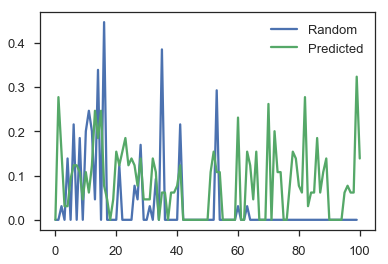

In [152]:
sampleAccuracy = []
for i in range(len(df)):
    sampleAccuracy.append(df.loc[i].values[1:-1].sum()/len(df.loc[i].values[0:-1]))

randomsampleAccuracy = []
for i in range(len(df2)):
    randomsampleAccuracy.append(df2.loc[i].values[0:-1].sum()/len(df2.loc[i].values[0:-1]))
plt.plot(randomsampleAccuracy, label='Random')
plt.plot(sampleAccuracy, label='Predicted')
plt.legend()

In [153]:
print(np.mean(randomsampleAccuracy), np.mean(sampleAccuracy))

nan 0.08103579588728105


In [93]:
randomsampleAccuracy
randomsampleAccuracy = [i for i in randomsampleAccuracy if i > 0]
sampleAccuracy = [i for i in sampleAccuracy if i > 0]

print(np.mean(randomsampleAccuracy), np.mean(sampleAccuracy))

0.11248423707440101 0.9848484848484845


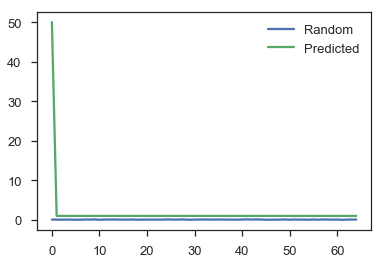

In [94]:
elementAccuracy = []
for element in range(65):
    elementAccuracy.append(df.iloc[0:,element].values.sum()/101)
    
randomelementAccuracy = []

for element in range(65):
    randomelementAccuracy.append(df2.iloc[0:,element].fillna(0).values.sum()/101)
plt.plot(randomelementAccuracy, label='Random')
plt.plot(elementAccuracy, label='Predicted')
plt.legend()

In [95]:
print(np.mean(randomelementAccuracy), np.mean(elementAccuracy))

0.06793602437166794 1.7538461538461538


In [1288]:
#df.to_csv(r'J:\Geology\WSGS\Projects\Critical Minerals\accuracy_50percent_probability_huc12.csv')